# Coronavirus Reverse Engineering

## Machine Learning for Genus Classification

The Coronaviridae family comprises enveloped positive-sense single-stranded RNA viruses of the order Nidovirales. The family is divided into Coronavirinae and Torovirinae sub-families, which are further divided into four genera: Alphacoronavirus, Betacoronavirus, Gammacoronavirus and Deltacoronavirus. Some of the samples in our database (from NCBI) are tagged with its genus, but most of them aren't. We can use that previous knowledge to train a classifier and find patterns in protein sequences for each group to classify the unknown ones.

Once we have that information available in our database, we can study the proteome of each genera separately to find clusters of coding sequences and discover proteins and preserved sequences among the members of each group.

In order to classify the genus of a given sample, we'll take the main proteins of the genome (ORF1A, ORF1AB, S, HE, E, M and N) for each entry in the database and perform a scan against our domain database using hmmscan to craft the features for the training set.

**TABLE OF CONTENTS**

* [Building the Training Set](#section1)
   * [Protein outliers](#section2)

In [1]:
from matplotlib import pyplot as plt

import nglview as nv

from IPython.display import display, HTML
from IPython.display import Markdown as md
from IPython.core.display import Image
import time

from sklearn.linear_model import LinearRegression
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

import joblib
import json

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.models import model_from_json

from reportlab.lib import colors
from reportlab.lib.units import cm

import matplotlib.pyplot as plt
import forgi.visual.mplotlib as fvm
import forgi
from nglview.contrib.movie import MovieMaker

from Bio.Seq import Seq
from Bio import Entrez
from Bio.Graphics import GenomeDiagram
from Bio import SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.Alphabet import IUPAC
from Bio.SeqUtils import seq3
from Bio import Align
from Bio.SeqRecord import SeqRecord
from Bio.PDB import *

import bisect 
import pandas as pd
import seaborn as sb
import numpy as np
import seaborn as sns
from scipy import stats
import math
import zlib
import pickle
from uuid import *

from intervaltree import Interval, IntervalTree
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words

import datetime
import os
import subprocess
import lzma as xz

# file periodically removed to update with the latest data
cache_vrs_file = ".cache_vrs.pkl" 
cache_corona_tagged_db = ".cache_corona_tagged_db.pkl"
cache_cds_file = ".cache_cds.pkl" 

orf1_rf_classifier = "./models/cds_orf1_rf.pkl" 

genera_classifier = {"genus": {"network_classifier": "./models/genus_nn.h5", 
                               "network_metadata": "./models/genus_nn.json",
                               "random_forest_classifier" : "./models/genus_rf.pkl"},
                     "subgenus": {"network_classifier": "./models/subgenus_nn.h5", 
                                  "network_metadata": "./models/subgenus_nn.json",
                                  "random_forest_classifier" : "./models/subgenus_rf.pkl"}}

hidden_columns = ["sequence", "file_path"]
hidden_regions_columns = ["id", "rna", "protein", "path"]
hidden_cds_columns = ["translation", "file_path", "location"]

if os.path.isfile(cache_vrs_file):
    corona = pd.read_pickle(cache_vrs_file)
    corona_cds = pd.read_pickle(cache_cds_file)
    
    # set index
    corona = corona.set_index("id")
    corona_cds = corona_cds.set_index("protein_id")

    # drop duplicates
    corona = corona[~corona.index.duplicated(keep='first')]
    corona_cds = corona_cds[~corona_cds.index.duplicated(keep='first')]
    
else:
    %run ./coronaversing.ipynb
    %run ./proteindb.ipynb
    
# get raw data (including genomes with incomplete sequence)
if os.path.isfile(cache_corona_tagged_db):
    corona_db = pd.read_pickle(cache_corona_tagged_db)

# generic function to print everything either for a protein or genome ID
def display_info(accs):
    protein_entry = corona_cds[corona_cds.index == accs]
    if len(protein_entry) > 0:   
        oid = protein_entry["oid"].values[0]
        cds = corona_cds[corona_cds["oid"] == oid]
        entry = corona[corona.index == oid]
        orfs = corona_db[corona_db["id"] == oid]
        
        display(HTML(entry.drop(hidden_columns, axis=1).to_html()))
        if len(cds) > 0 :
            display(HTML(cds.drop(hidden_cds_columns, axis=1).to_html()))
        display(HTML(orfs.drop(hidden_regions_columns, axis=1).to_html()))

        return
    
    entry = corona[corona.index == accs]
    if len(entry) > 0:
        oid = accs
        cds = corona_cds[corona_cds["oid"] == oid]
        orfs = corona_db[corona_db["id"] == oid]
        
        display(HTML(entry.drop(hidden_columns, axis=1).to_html()))
        if len(cds) > 0 :
            display(HTML(cds.drop(hidden_cds_columns, axis=1).to_html()))
        display(HTML(orfs.drop(hidden_regions_columns, axis=1).to_html()))

        return

_ColormakerRegistry()

Using TensorFlow backend.


# 5. Building the Training Set <a id="section1"></a>

Before training the classifier, let's take a look at the proteins that were tagged in a previous [notebook](./proteindb.ipynb) and find outliers in the database.

## 5.1 Proteins outliers

[Isolations Forest](https://en.wikipedia.org/wiki/Isolation_forest) it's a pretty neat method to identify outliers in high dimensional data, which works a bit different than other techniques. Instead of profiling normal points, it works by isolating anomalies.

Let's refresh our domain database for each ORF in every genome of our database.

In [2]:
SCAN_FILE = "./data/pfam/matches_cds.scan"

def get_domain_matches(scan_file, ecutoff):
    columns = ["id", "domain", "accession", "score", "from", "to", "hits"]
    domains_frame = {i: list() for i in columns}

    with open(scan_file) as matches_file:
        for line in matches_file:
            row = line[:-1]
            if row != "#":
                toks = row.split()
                    
                # domain
                domain = toks[0]

                # accession number
                acc = toks[1].split(".")[0]
                
                if "PF" in acc:
                    total = int(toks[10])
                    ievalue = float(toks[12])
                                        
                    if ievalue > ecutoff:
                        continue
                        
                    domains_frame["accession"].append(acc)
                    domains_frame["domain"].append(domain)

                    # protein id
                    domains_frame["id"].append(toks[3])
                    
                    # score
                    domains_frame["score"].append(float(toks[7]))
                        
                    domains_frame["from"].append(int(toks[17]))
                    domains_frame["to"].append(int(toks[18]))

                    # times this domain appears 
                    domains_frame["hits"].append(total)

    domain_matches = pd.DataFrame.from_dict(domains_frame)

    return domain_matches

ecutoff = 1e-2
pfam_matches = get_domain_matches(SCAN_FILE, ecutoff)

freqs = pfam_matches["domain"].value_counts()
display(HTML(freqs.reset_index().head(15).to_html()))

,index,domain
0,CoV_peptidase,17270
1,CoV_NSP2_C,15524
2,CoV_NSP4_N,14323
3,CoV_NSP6,14322
4,CoV_NSP3_C,14320
5,CoV_NSP8,14317
6,CoV_NSP10,14317
7,Peptidase_C30,14314
8,CoV_NSP9,14308
9,CoV_NSP4_C,14303


THe following function creates the training set for a given set of ORFs

In [3]:
def get_training_set(orfs, domain_matches):
    label = orfs.iloc[0]["label"]
    
    columns = [label + "_length"]

    domain_count = domain_matches.groupby(["domain", "id"]).size().reset_index(name="count")
    domain_count = domain_count.groupby("domain").max()["count"].reset_index(name="count")
    domain_count = domain_count.set_index("domain").to_dict()

    for domain in domain_count["count"]:
        count = domain_count["count"][domain]
        columns += [label + "_" + domain + "_hits"]
        for i in range(1, count + 1):
            columns += [label + "_" + domain + "_from_" + str(i), 
                        label + "_" + domain + "_to_" + str(i), 
                        label + "_" + domain + "_score_" + str(i)]

    dataset_frame = {i: dict() for i in columns}

    for index, row in orfs.iterrows():
        length = float(row["length"]) / 3.0
        dataset_frame[label + "_length"][index] = length

        count = {}
        pfam = domain_matches[domain_matches["id"] == index][["domain", "score", "from", "to", "hits"]]
        pfam = pfam.set_index("domain")
        for i, r in pfam.iterrows():

            # increment counter
            if i not in count:
                count[i] = 1
                dataset_frame[label + "_" + i + "_hits"][index] = r["hits"]
            else:
                count[i] += 1

            dataset_frame[label + "_" + i + "_score_" + str(count[i])][index] = r["score"]
            dataset_frame[label + "_" + i + "_from_" + 
                          str(count[i])][index] = float(r["from"]) / length
            dataset_frame[label + "_" + i + "_to_" + 
                          str(count[i])][index] = float(r["to"]) / length
            
    training_df = pd.DataFrame(dataset_frame)
    training_df.index.name = "id"

    return training_df

def show_features(index):
    row = training_df_s[training_df_s.index == index].transpose()
    row = row[row > 0].dropna()
    display(HTML(row.reset_index().to_html()))
    
def show_pfam(index):
    row = pfam_matches[pfam_matches["id"] == index]
    display(HTML(row.to_html()))

Let's go over each protein tagged so far and get the top %3 most anomalous samples for each case and plot the length distribution.

In [4]:
LABELS = ["ORF1AB", "S", "HE", "E", "M", "N"]

anomaly_score = {}
training_dfs = {}
for label in LABELS:
    orfs = corona_db[corona_db["label"] == label]
    pfam = pfam_matches[pfam_matches["id"].isin(orfs.index)]

    tdf = get_training_set(orfs, pfam).fillna(0)
    
    x_train = tdf.values
    rf_outliers = IsolationForest().fit(x_train)

    score_dataframe = {"id" : tdf.index, "score" : abs(rf_outliers.score_samples(x_train))}
    score_anomalies = pd.DataFrame(score_dataframe)
    score_anomalies = score_anomalies.set_index("id").sort_values("score")
    
    anomaly_score[label] = score_anomalies
    training_dfs[label] = tdf

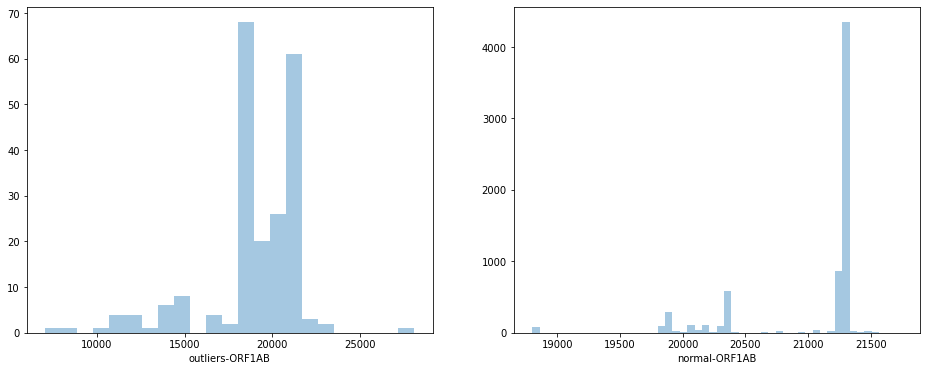

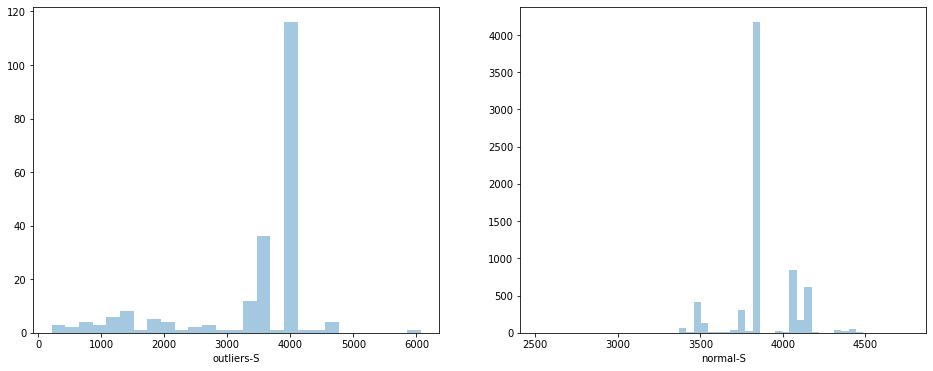

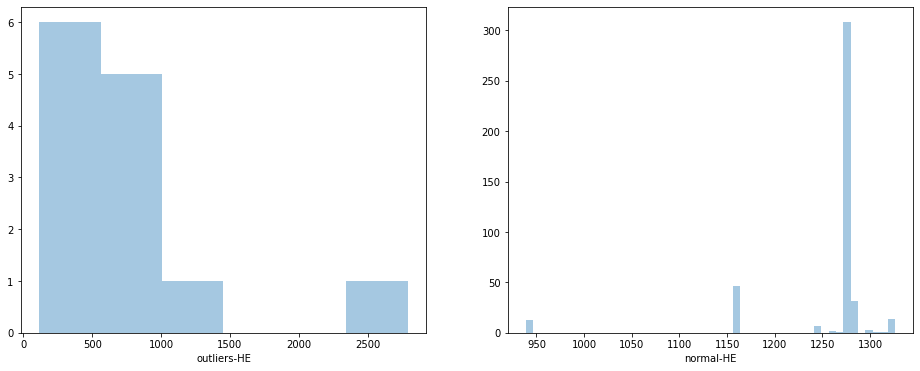

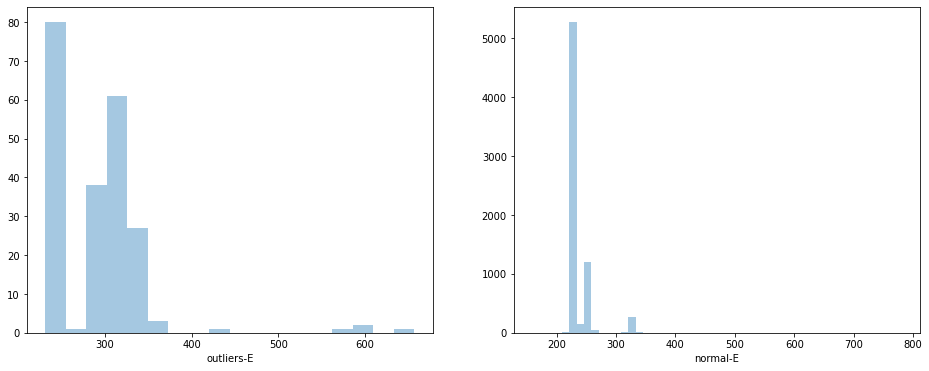

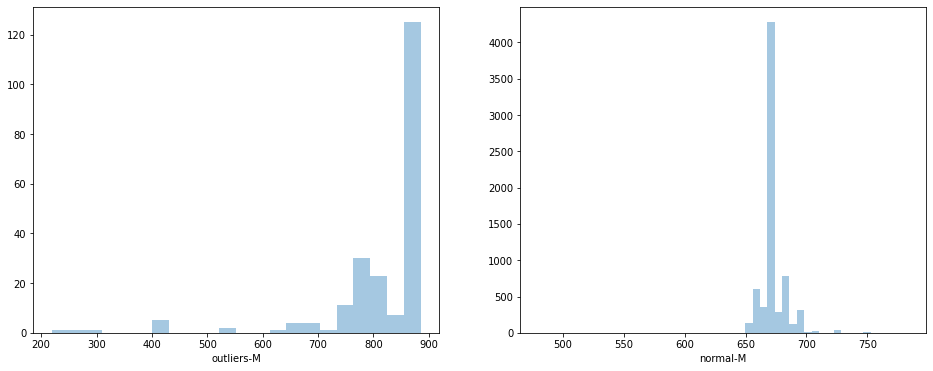

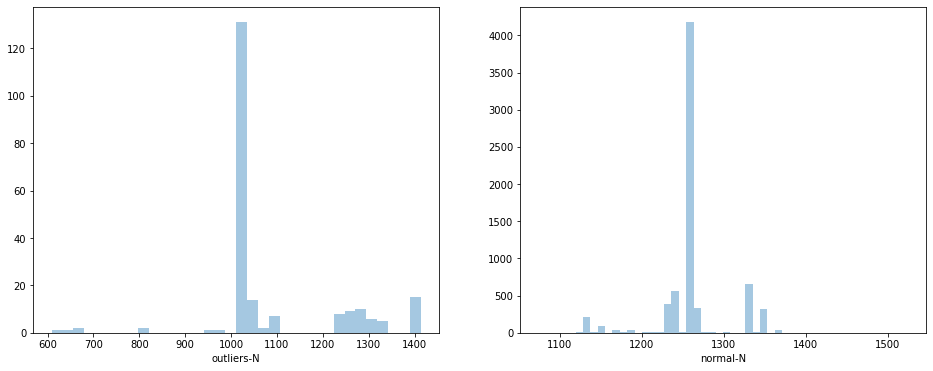

In [5]:
CONTAMINATION = 0.03

for label in LABELS:
    scores = anomaly_score[label]
    outliers_ids = scores.tail(int(CONTAMINATION * len(scores)))
    normal_ids = scores[~scores.index.isin(outliers_ids.index.values)]
        
    outliers = corona_db[corona_db.index.isin(outliers_ids.index.values)]
    normal = corona_db[corona_db.index.isin(normal_ids.index.values)]

    fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
    sns.distplot(outliers["length"], kde=False, ax=axs[0], axlabel = "outliers-" + label);
    sns.distplot(normal["length"], kde=False, ax=axs[1], axlabel = "normal-" + label);

## 5.2 Genus classifier

In order to build the training set, we'll use the domain hits for each one of the main proteins type as features. 

In [6]:
def get_dataset(class_name, unknown=False):
    genus_columns = []
    for label in LABELS:
        for c in training_dfs[label].columns:
            genus_columns.append(c)        
    genus_columns += [class_name]

    # create genus dataset
    genus_dataset_frame = {i: dict() for i in genus_columns}
    if not unknown:
        rows_genus = corona_db[corona_db[class_name] != "unknown"]
    else:
        rows_genus = corona_db[corona_db[class_name] == "unknown"]

    for oid in rows_genus["id"].unique():
        for label in LABELS:
            orfs = rows_genus[rows_genus["id"] == oid]
            protein = orfs[orfs["label"] == label]

            if len(protein) > 0:
                rid = protein.index.values[0]
                tdf = training_dfs[label][training_dfs[label].index == rid]

                for z in tdf:
                    genus_dataset_frame[z][oid] = tdf[z].values[0]

        genus_dataset_frame[class_name][oid] = orfs.iloc[0][class_name]

    genus_tdf = pd.DataFrame(genus_dataset_frame)
    genus_tdf.index.name = "id"

    return genus_tdf

genus_tdf = get_dataset("genus")
subgenus_tdf = get_dataset("subgenus")
    
print("[+] got", len(genus_tdf), "genus training points")
print("[+] got", len(subgenus_tdf), "subgenus training points")

[+] got 3424 genus training points
[+] got 1755 subgenus training points


Let's see how many sample we have of each genera of the virus.

In [7]:
corona.groupby("genus").size().reset_index(name="count").sort_values(by="count", ascending=False)

,genus,count
4,unknown,3825
1,betacoronavirus,2003
0,alphacoronavirus,1028
3,gammacoronavirus,408
2,deltacoronavirus,103


In [8]:
corona.groupby("subgenus").size().reset_index(name="count").sort_values(by="count", ascending=False)

,subgenus,count
23,unknown,5507
20,sarbecovirus,920
6,embecovirus,265
9,igacovirus,166
18,pedacovirus,130
22,tegacovirus,94
1,buldecovirus,91
11,merbecovirus,59
5,duvinacovirus,55
21,setracovirus,15


Now, lets' train a neural network pretty much like the CDS tagging case.

In [9]:
def evaluate_classifier(tdf, pdf, class_name):
    cls = tdf[class_name].unique()
    target_names = cls

    hits = (tdf[class_name].values == pdf[class_name].values)

    accuracy = float(np.count_nonzero(hits)) / float(len(hits))

    matrix = confusion_matrix(tdf[class_name].values,pdf[class_name].values)

    mdf = pd.DataFrame(matrix, columns=cls)
    mdf.index = cls
    display(HTML(mdf.to_html()))

    report = classification_report(tdf[class_name].values, pdf[class_name].values, target_names=target_names, output_dict=True)
    repdf = pd.DataFrame(report).transpose()
    display(HTML(repdf.to_html()))
    
    return report
    
def train_network(tdf, class_name, store_model=False):
    tdf = tdf.fillna(0)
    
    # get classes
    cls = tdf[class_name].unique()
    class_map = {tp: i for tp, i in zip(cls, range(0, len(cls)))}

    # get training data
    t_data = tdf.values

    # training set
    x_train = t_data[:, :-1]
    y_train = np.vectorize(class_map.get)(t_data[:, -1])

    class_weights = class_weight.compute_class_weight("balanced", np.unique(y_train), y_train)

    y_train = to_categorical(y_train)

    network = Sequential()
    network.add(Dense(48, activation="relu", input_shape=(len(x_train[0]),)))
    network.add(Dropout(0.2))
    network.add(Dense(24, activation="relu"))
    network.add(Dropout(0.1))
    network.add(Dense(24, activation="relu"))
    network.add(Dense(len(y_train[0]), activation="softmax"))

    # compile network
    network.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

    # train network
    network.fit(x_train, y_train, epochs=50, batch_size=8, class_weight=class_weights, verbose=0)

    if store_model:
        # create JSON with metadata about the model
        network_data = {"cutoff": "-E 1e-2", "features": list(tdf.columns.values[:-1]), "classes": class_map}
        with open(genera_classifier[class_name]["network_metadata"], "w") as fp:
            json.dump(network_data, fp)

        # serialize weights to HDF5
        network.save(genera_classifier[class_name]["network_classifier"])
        print("[+] saved model to disk")
        
    return network

def predict_network(model, pdf, class_name):
    tdf = pdf.fillna(0)
    
    # get classes
    cls = tdf[class_name].unique()
    class_map = {tp: i for tp, i in zip(cls, range(0, len(cls)))}
    categories_map = {v: k for k, v in class_map.items()}

    x = tdf.values[:, :-1]
    y_pred = model.predict(x)

    y_pred = np.vectorize(categories_map.get)(y_pred.argmax(axis=1))
    tdf["predicted"] = y_pred

    return pd.DataFrame(tdf["predicted"].values, index=tdf["predicted"].index.values, columns=[class_name])

We'll run a 5-fold cross validation randomly splitting our training set and leaving 20% of the samples as the testing set.  

In [10]:
kfold = 5
accuracy = 0.0

for i in range(0, kfold):
    print("[+] neural network run", i)
    # split our training set
    genus_train, genus_test = pd.DataFrame(columns=genus_tdf.columns), pd.DataFrame(columns=genus_tdf.columns)
    genus_train.index.name, genus_test.index.name = genus_tdf.index.name, genus_tdf.index.name
    for genera in genus_tdf["genus"].unique():
        genus_total = genus_tdf[genus_tdf["genus"] == genera]
        
        df = pd.DataFrame(np.random.randn(len(genus_total), 2))
        msk = np.random.rand(len(df)) < 0.80
        genus_train_case = genus_total[msk]
        genus_test_case = genus_total[~msk]
        
        genus_train = pd.concat([genus_train, genus_train_case])
        genus_test = pd.concat([genus_test, genus_test_case])

    # train the random forest
    genus_classifer = train_network(genus_train, "genus")

    # evaluate
    genus_predict = predict_network(genus_classifer, genus_test, "genus")
    report = evaluate_classifier(genus_test, genus_predict, "genus")
    
    accuracy += report["accuracy"]
    
accuracy /= kfold
print("[+] cross validation average accuracy = %.2f" %(accuracy * 100))

print("[+] final neural network run")

    # train the random forest
genus_classifer = train_network(genus_tdf, "genus", store_model=True)

# evaluate
genus_predict = predict_network(genus_classifer, genus_tdf, "genus")
report = evaluate_classifier(genus_tdf, genus_predict, "genus")

[+] neural network run 0


,betacoronavirus,alphacoronavirus,gammacoronavirus,deltacoronavirus
betacoronavirus,192,0,0,0
alphacoronavirus,2,369,0,0
gammacoronavirus,0,0,17,0
deltacoronavirus,0,0,0,83


,precision,recall,f1-score,support
betacoronavirus,0.989691,1.000000,0.994819,192.000000
alphacoronavirus,1.000000,0.994609,0.997297,371.000000
gammacoronavirus,1.000000,1.000000,1.000000,17.000000
deltacoronavirus,1.000000,1.000000,1.000000,83.000000
accuracy,0.996983,0.996983,0.996983,0.996983
macro avg,0.997423,0.998652,0.998029,663.000000
weighted avg,0.997015,0.996983,0.996987,663.000000


[+] neural network run 1


,betacoronavirus,alphacoronavirus,gammacoronavirus,deltacoronavirus
betacoronavirus,179,0,0,2
alphacoronavirus,0,376,0,0
gammacoronavirus,0,0,23,0
deltacoronavirus,0,0,0,79


,precision,recall,f1-score,support
betacoronavirus,1.000000,0.988950,0.994444,181.000000
alphacoronavirus,1.000000,1.000000,1.000000,376.000000
gammacoronavirus,1.000000,1.000000,1.000000,23.000000
deltacoronavirus,0.975309,1.000000,0.987500,79.000000
accuracy,0.996965,0.996965,0.996965,0.996965
macro avg,0.993827,0.997238,0.995486,659.000000
weighted avg,0.997040,0.996965,0.996976,659.000000


[+] neural network run 2


,betacoronavirus,alphacoronavirus,gammacoronavirus,deltacoronavirus
betacoronavirus,204,1,0,1
alphacoronavirus,2,378,0,0
gammacoronavirus,0,0,18,0
deltacoronavirus,0,0,0,79


,precision,recall,f1-score,support
betacoronavirus,0.990291,0.990291,0.990291,206.000000
alphacoronavirus,0.997361,0.994737,0.996047,380.000000
gammacoronavirus,1.000000,1.000000,1.000000,18.000000
deltacoronavirus,0.987500,1.000000,0.993711,79.000000
accuracy,0.994143,0.994143,0.994143,0.994143
macro avg,0.993788,0.996257,0.995012,683.000000
weighted avg,0.994158,0.994143,0.994145,683.000000


[+] neural network run 3


,betacoronavirus,alphacoronavirus,gammacoronavirus,deltacoronavirus
betacoronavirus,207,2,1,0
alphacoronavirus,1,381,0,0
gammacoronavirus,0,0,20,0
deltacoronavirus,0,0,0,93


,precision,recall,f1-score,support
betacoronavirus,0.995192,0.985714,0.990431,210.000000
alphacoronavirus,0.994778,0.997382,0.996078,382.000000
gammacoronavirus,0.952381,1.000000,0.975610,20.000000
deltacoronavirus,1.000000,1.000000,1.000000,93.000000
accuracy,0.994326,0.994326,0.994326,0.994326
macro avg,0.985588,0.995774,0.990530,705.000000
weighted avg,0.994388,0.994326,0.994333,705.000000


[+] neural network run 4


,betacoronavirus,alphacoronavirus,gammacoronavirus,deltacoronavirus
betacoronavirus,208,1,0,0
alphacoronavirus,1,378,0,0
gammacoronavirus,0,0,30,0
deltacoronavirus,0,0,0,89


,precision,recall,f1-score,support
betacoronavirus,0.995215,0.995215,0.995215,209.000000
alphacoronavirus,0.997361,0.997361,0.997361,379.000000
gammacoronavirus,1.000000,1.000000,1.000000,30.000000
deltacoronavirus,1.000000,1.000000,1.000000,89.000000
accuracy,0.997171,0.997171,0.997171,0.997171
macro avg,0.998144,0.998144,0.998144,707.000000
weighted avg,0.997171,0.997171,0.997171,707.000000


[+] cross validation average accuracy = 99.59
[+] final neural network run
[+] saved model to disk


,betacoronavirus,alphacoronavirus,gammacoronavirus,deltacoronavirus
betacoronavirus,1012,2,1,0
alphacoronavirus,1,1898,0,0
gammacoronavirus,0,0,103,0
deltacoronavirus,0,0,0,407


,precision,recall,f1-score,support
betacoronavirus,0.999013,0.997044,0.998028,1015.000000
alphacoronavirus,0.998947,0.999473,0.999210,1899.000000
gammacoronavirus,0.990385,1.000000,0.995169,103.000000
deltacoronavirus,1.000000,1.000000,1.000000,407.000000
accuracy,0.998832,0.998832,0.998832,0.998832
macro avg,0.997086,0.999129,0.998102,3424.000000
weighted avg,0.998834,0.998832,0.998832,3424.000000


The genus classifier has a pretty good performance, which indicates that is a pretty well defined problem and there is a clear separation in the data that fits the genera classification. Something we should look at is the importances of each features to discriminate the samples on each genera. 

As an alternative, we can also evaluate the performance of a random forest, which might be a pretty good option since we don't have any scalability concerns about the size of our dataset. Even more, a random forest run will also give us an estimate of the importance for each feature used for classification, which might be useful to understand the underlying logic used to classify coronaviruses genomes in different genera. 

In [11]:
def train_random_forest(tdf, class_name):
    tdf = tdf.fillna(0)
    
    # get classes
    cls = tdf[class_name].unique()
    orf1a_class_map = {tp: i for tp, i in zip(cls, range(0, len(cls)))}

    t_data = tdf.values

    # training set
    x_train = t_data[:, :-1]
    y_train = np.vectorize(orf1a_class_map.get)(t_data[:, -1])

    rf_classifier = RandomForestClassifier()
    rf_classifier.fit(x_train, y_train)
            
    return rf_classifier

def predict_random_forest(model, pdf, class_name):
    tdf = pdf.fillna(0)
    
    # get classes
    cls = tdf[class_name].unique()
    class_map = {tp: i for tp, i in zip(cls, range(0, len(cls)))}
    categories_map = {v: k for k, v in class_map.items()}

    x = tdf.values[:, :-1]
    y_pred = model.predict(x)

    y_pred = np.vectorize(categories_map.get)(y_pred)
    tdf["predicted"] = y_pred

    return pd.DataFrame(tdf["predicted"].values, index=tdf["predicted"].index.values, columns=[class_name])

def get_importances(model, feature_names):
    importances = pd.DataFrame(np.transpose(model.feature_importances_), 
                               columns=["importances"])
    importances.index = feature_names
    importances = importances.sort_values("importances", ascending=False)
    
    return importances

Let's run a 5-fold cross validation using 80% as a training set just like the neural case before and compute the average accuracy for each run. 

In [12]:
kfold = 5
accuracy = 0.0

for i in range(0, kfold):
    print("[+] random forest run", i)
    # split our training set
    genus_train, genus_test = pd.DataFrame(columns=genus_tdf.columns), pd.DataFrame(columns=genus_tdf.columns)
    genus_train.index.name, genus_test.index.name = genus_tdf.index.name, genus_tdf.index.name
    for genera in genus_tdf["genus"].unique():
        genus_total = genus_tdf[genus_tdf["genus"] == genera]
        
        df = pd.DataFrame(np.random.randn(len(genus_total), 2))
        msk = np.random.rand(len(df)) < 0.80
        genus_train_case = genus_total[msk]
        genus_test_case = genus_total[~msk]
        
        genus_train = pd.concat([genus_train, genus_train_case])
        genus_test = pd.concat([genus_test, genus_test_case])

    # train the random forest
    genus_random_forest = train_random_forest(genus_train, "genus")

    # evaluate
    genus_predict = predict_random_forest(genus_random_forest, genus_test, "genus")
    report = evaluate_classifier(genus_test, genus_predict, "genus")

    accuracy += report["accuracy"]
    
accuracy /= kfold
print("[+] cross validation average accuracy = %.2f" %(accuracy * 100))

print("[+] final random forest run")

# train the random forest
genus_random_forest = train_random_forest(genus_tdf, "genus")

# evaluate
genus_predict = predict_random_forest(genus_random_forest, genus_tdf, "genus")
report = evaluate_classifier(genus_tdf, genus_predict, "genus")

# serialize classifier
joblib.dump(genus_random_forest, genera_classifier["genus"]["random_forest_classifier"], compress=9)
print("[+] saved random forest to disk")

importances = get_importances(genus_random_forest, genus_tdf.columns.values[:-1])
display(HTML(importances.head(15).to_html()))

[+] random forest run 0


,betacoronavirus,alphacoronavirus,gammacoronavirus,deltacoronavirus
betacoronavirus,199,0,0,0
alphacoronavirus,0,384,0,0
gammacoronavirus,0,0,22,0
deltacoronavirus,0,0,0,85


,precision,recall,f1-score,support
betacoronavirus,1.0,1.0,1.0,199.0
alphacoronavirus,1.0,1.0,1.0,384.0
gammacoronavirus,1.0,1.0,1.0,22.0
deltacoronavirus,1.0,1.0,1.0,85.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,690.0
weighted avg,1.0,1.0,1.0,690.0


[+] random forest run 1


,betacoronavirus,alphacoronavirus,gammacoronavirus,deltacoronavirus
betacoronavirus,199,0,0,0
alphacoronavirus,1,379,0,0
gammacoronavirus,0,0,14,0
deltacoronavirus,0,0,0,68


,precision,recall,f1-score,support
betacoronavirus,0.995000,1.000000,0.997494,199.000000
alphacoronavirus,1.000000,0.997368,0.998682,380.000000
gammacoronavirus,1.000000,1.000000,1.000000,14.000000
deltacoronavirus,1.000000,1.000000,1.000000,68.000000
accuracy,0.998487,0.998487,0.998487,0.998487
macro avg,0.998750,0.999342,0.999044,661.000000
weighted avg,0.998495,0.998487,0.998488,661.000000


[+] random forest run 2


,betacoronavirus,alphacoronavirus,gammacoronavirus,deltacoronavirus
betacoronavirus,208,0,0,0
alphacoronavirus,0,368,0,0
gammacoronavirus,0,0,19,0
deltacoronavirus,0,0,0,82


,precision,recall,f1-score,support
betacoronavirus,1.0,1.0,1.0,208.0
alphacoronavirus,1.0,1.0,1.0,368.0
gammacoronavirus,1.0,1.0,1.0,19.0
deltacoronavirus,1.0,1.0,1.0,82.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,677.0
weighted avg,1.0,1.0,1.0,677.0


[+] random forest run 3


,betacoronavirus,alphacoronavirus,gammacoronavirus,deltacoronavirus
betacoronavirus,203,0,0,0
alphacoronavirus,0,385,0,0
gammacoronavirus,0,0,19,0
deltacoronavirus,0,0,0,93


,precision,recall,f1-score,support
betacoronavirus,1.0,1.0,1.0,203.0
alphacoronavirus,1.0,1.0,1.0,385.0
gammacoronavirus,1.0,1.0,1.0,19.0
deltacoronavirus,1.0,1.0,1.0,93.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,700.0
weighted avg,1.0,1.0,1.0,700.0


[+] random forest run 4


,betacoronavirus,alphacoronavirus,gammacoronavirus,deltacoronavirus
betacoronavirus,214,1,0,0
alphacoronavirus,0,390,0,0
gammacoronavirus,0,0,23,0
deltacoronavirus,0,0,0,74


,precision,recall,f1-score,support
betacoronavirus,1.000000,0.995349,0.997669,215.000000
alphacoronavirus,0.997442,1.000000,0.998720,390.000000
gammacoronavirus,1.000000,1.000000,1.000000,23.000000
deltacoronavirus,1.000000,1.000000,1.000000,74.000000
accuracy,0.998575,0.998575,0.998575,0.998575
macro avg,0.999361,0.998837,0.999097,702.000000
weighted avg,0.998579,0.998575,0.998575,702.000000


[+] cross validation average accuracy = 99.94
[+] final random forest run


,betacoronavirus,alphacoronavirus,gammacoronavirus,deltacoronavirus
betacoronavirus,1015,0,0,0
alphacoronavirus,0,1899,0,0
gammacoronavirus,0,0,103,0
deltacoronavirus,0,0,0,407


,precision,recall,f1-score,support
betacoronavirus,1.0,1.0,1.0,1015.0
alphacoronavirus,1.0,1.0,1.0,1899.0
gammacoronavirus,1.0,1.0,1.0,103.0
deltacoronavirus,1.0,1.0,1.0,407.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,3424.0
weighted avg,1.0,1.0,1.0,3424.0


[+] saved random forest to disk


,importances
S_bCoV_S1_RBD_from_1,0.038038
S_bCoV_S1_RBD_to_1,0.037838
N_CoV_nucleocap_from_1,0.037108
S_bCoV_S1_N_to_1,0.036489
ORF1AB_bCoV_NAR_to_1,0.030688
ORF1AB_CoV_NSP2_C_to_1,0.030061
S_bCoV_S1_N_score_1,0.025971
S_bCoV_S1_RBD_hits,0.025407
ORF1AB_CoV_RPol_N_from_1,0.025242
ORF1AB_bCoV_NAR_score_1,0.024527


The random forest classifier shows a much better performance than the neural network, so we'll stick with this last model for genera classification. Neural networks posses an advantage when dealing and scaling on very large datasets, which is not needed at the moment.

Let's plot the distribution of the most important features for each class to have a visual comparison among each class of genera (in descending importance order) 

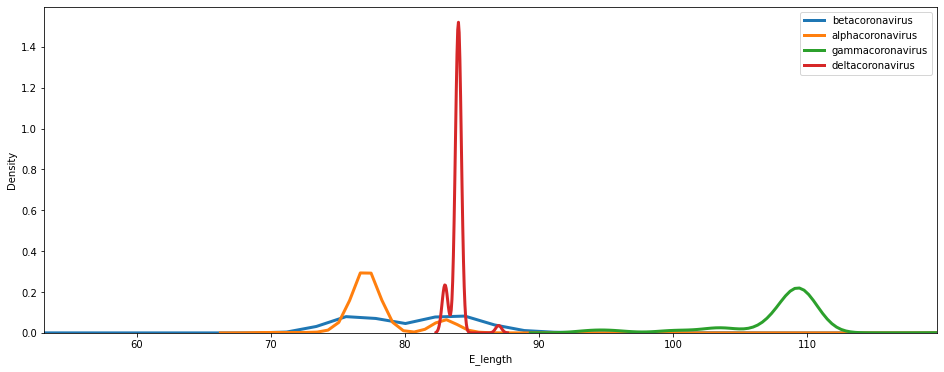

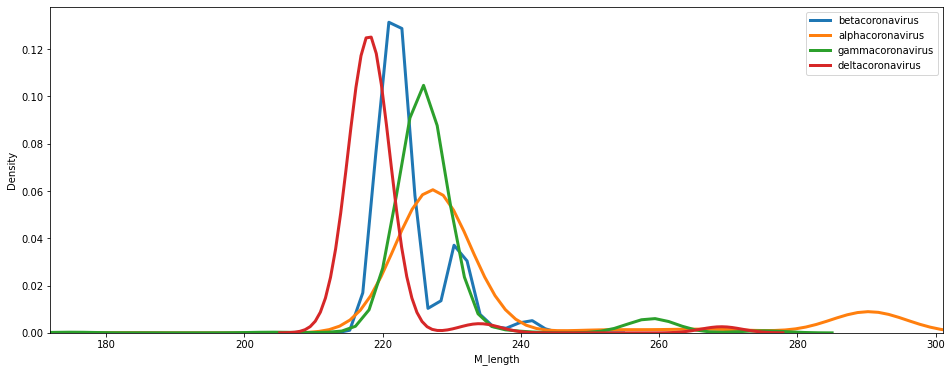

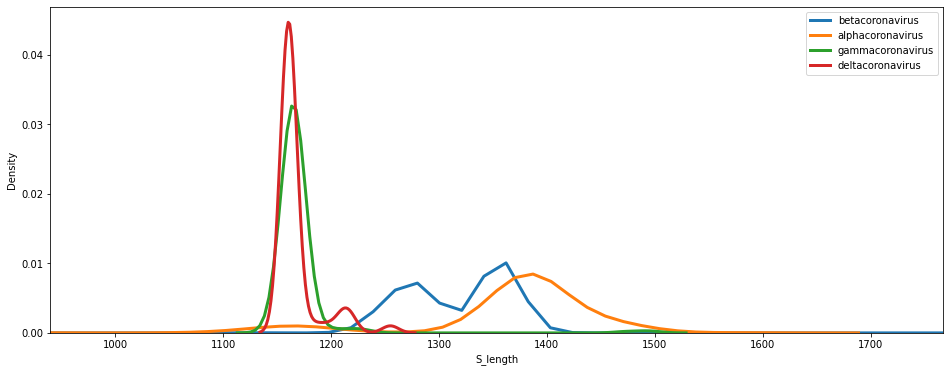

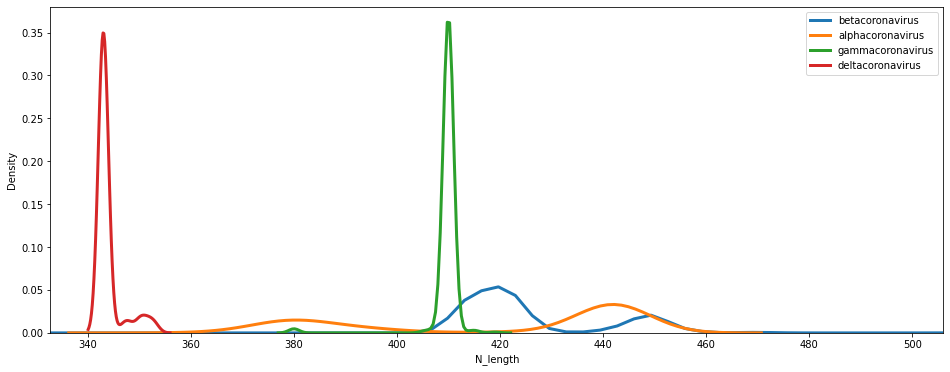

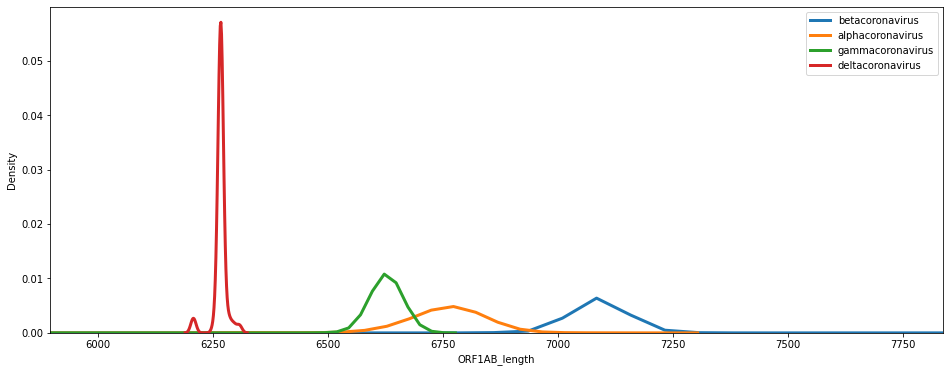

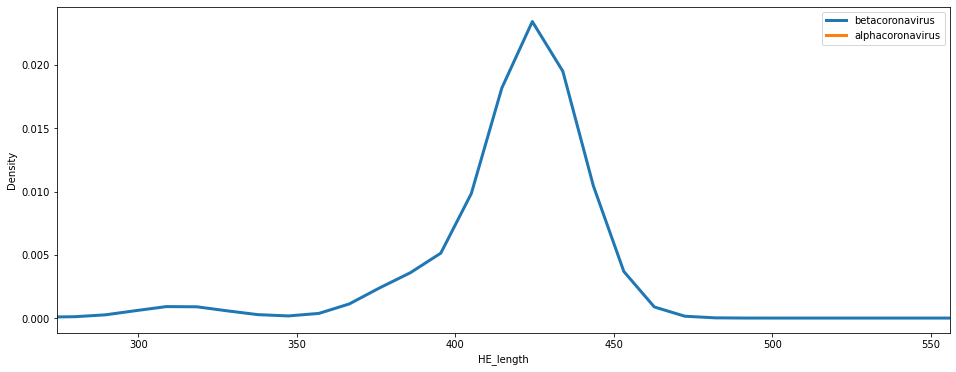

In [25]:
def plot_feature_length(class_name, tdf, feature):
    plt.figure(figsize=(16, 6))

    plt.xlabel(feature)
    plt.ylabel("Density")
    
    # Iterate through each case
    classes = tdf[class_name].unique()
    range_min, range_max = [], []
    for cls in classes:
        # Subset to the airline
        subset = tdf[tdf[class_name] == cls]

        # Draw the density plot
        distribution = subset[feature].dropna()
        ax = sns.distplot(distribution, hist = False, kde = True, kde_kws = {"linewidth": 3}, label=cls)

        # get distribution parameters
        mean = distribution.mean()
        std = distribution.std()
        
        range_min.append(mean - 3 * std)
        range_max.append(mean + 3 * std)

    ax.set_xlim(min(range_min), max(range_max))

# Plot formatting
for feature in importances.index:
    if "length" in feature:
        plot_feature_length("genus", genus_tdf, feature)

It's pretty clear that the ORF1AB gene size is quite an important differentiator for the virus genera. Deltacoronaviruses have a pretty sharp distribution with an average ORF1AB  size smaller than the others. For the rest of the classes, the ORF1AB gene size is bigger and the average value (peak of the distribution) is differentiated among them.

The M protein distribution overlaps for each genera which indicates that the size of this sequence is very similar for each case. The spike protein seems to have a similar size and dispersion for alpha and beta coronaviruses and a lower value and sharper distribution for gamma and delta coronaviruses. The HE protein seems to be present only in betacoronaviruses.

There is a pretty nice way to put this kind of data together with pairplots, which helps to visualize the protein size correlation for each class. 

<Figure size 1152x3024 with 0 Axes>

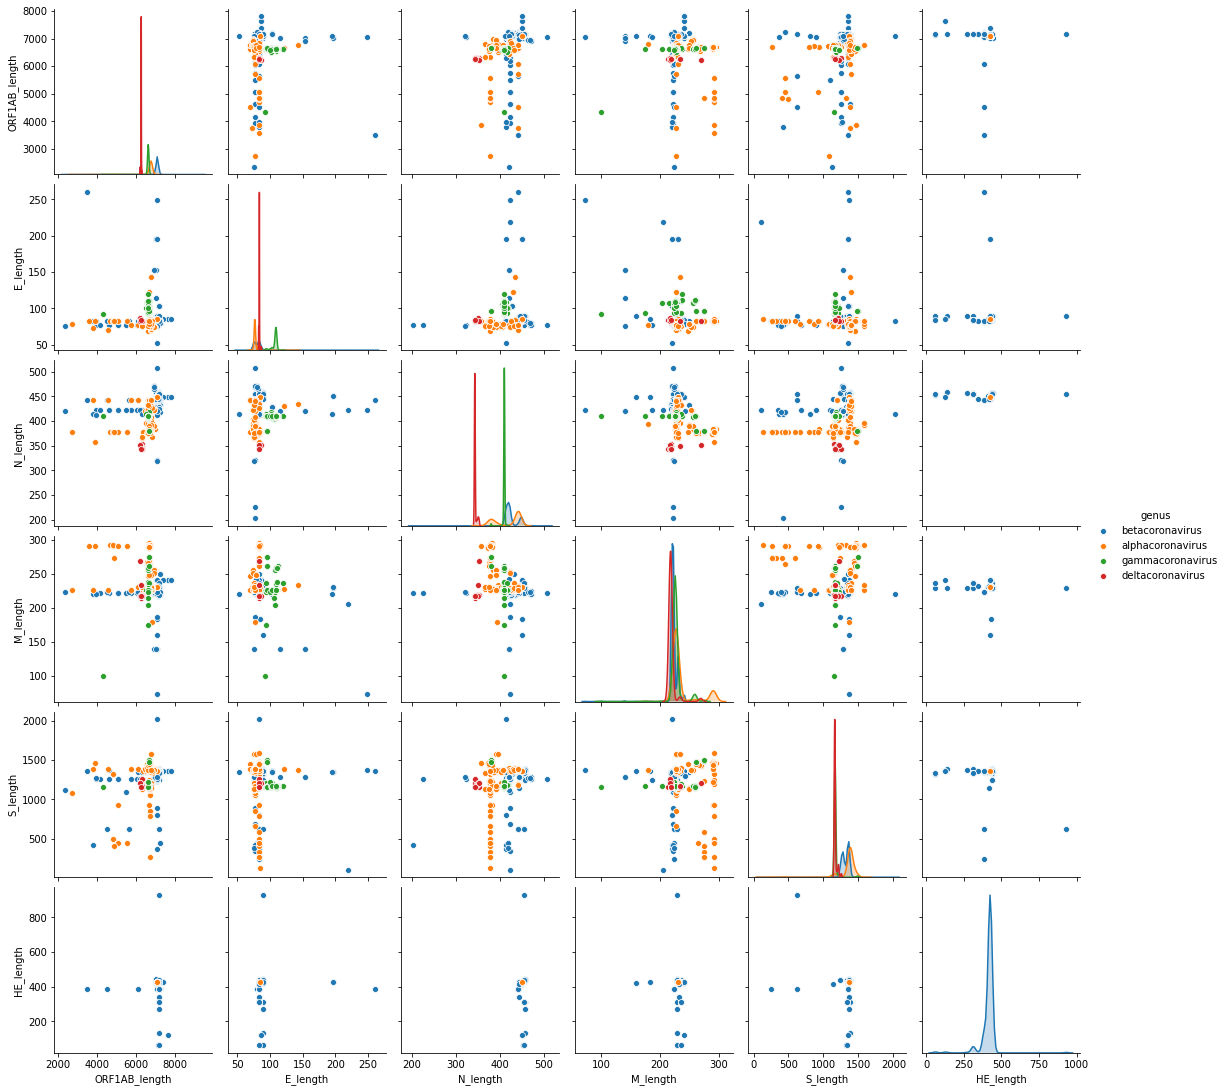

In [14]:
gene_lengths = []
for feature in importances.index:
    if "length" in feature:
        gene_lengths.append(feature)
gene_lengths.append("genus")

plt.figure(figsize=(16, 42));
ax = sns.pairplot(genus_tdf[gene_lengths], hue="genus");

Just by looking at the size of this genes is not enough to differentiate between each category. There are a bunch of protein domains that are relevant for classification. In order to visualize that, we'll plot the "from" position of a domain hit as abscissae and the "to" position as ordinates. Viral genomes of the same genera should cluster in different regions, assuming a domain is present among all cases but at different locations within a protein.

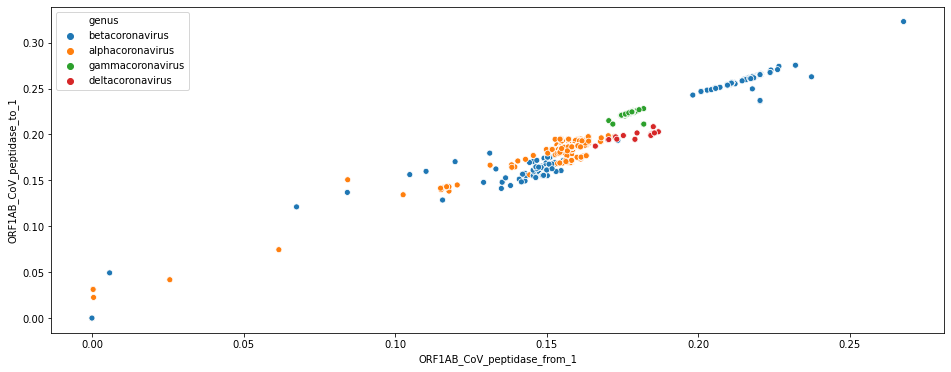

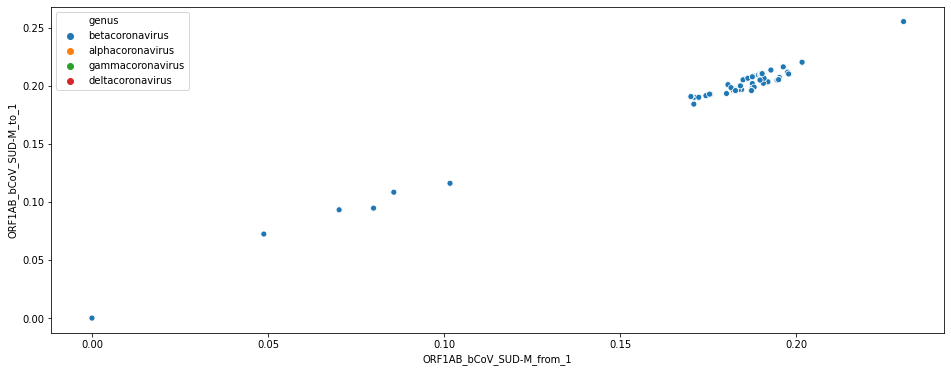

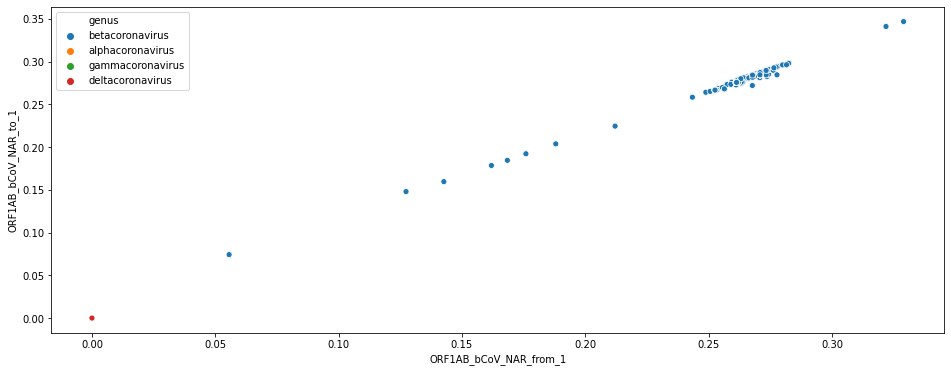

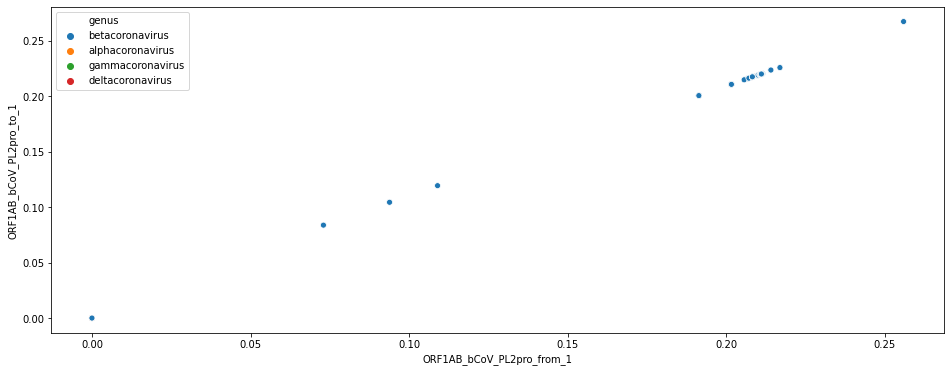

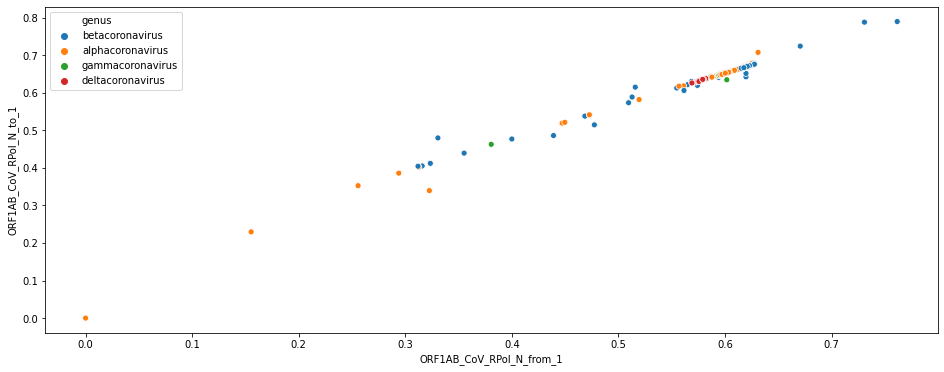

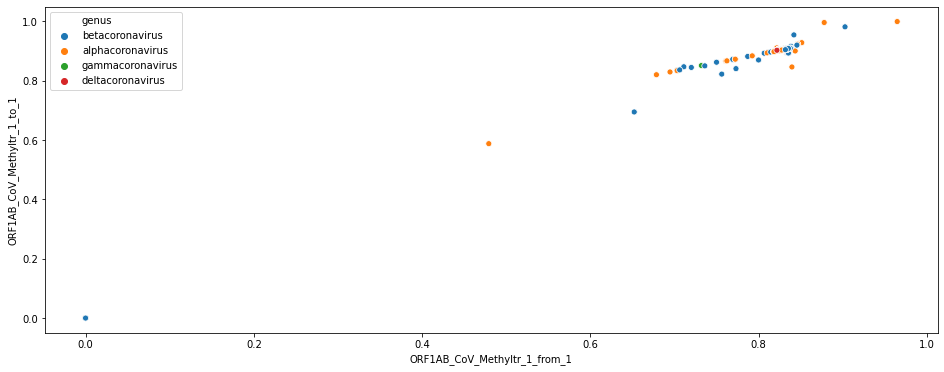

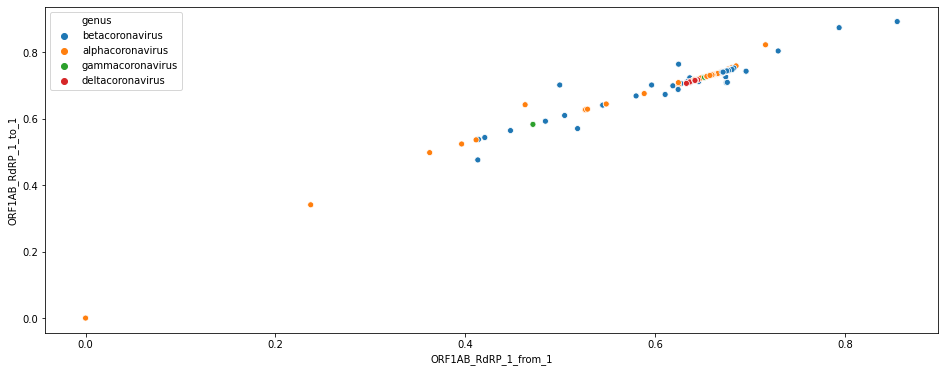

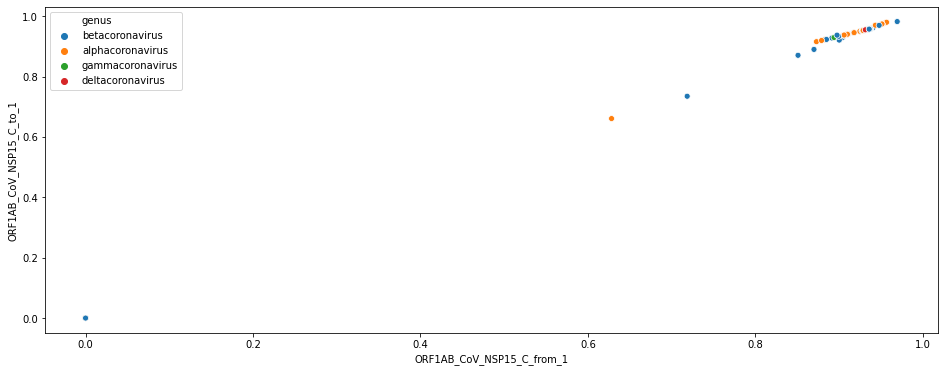

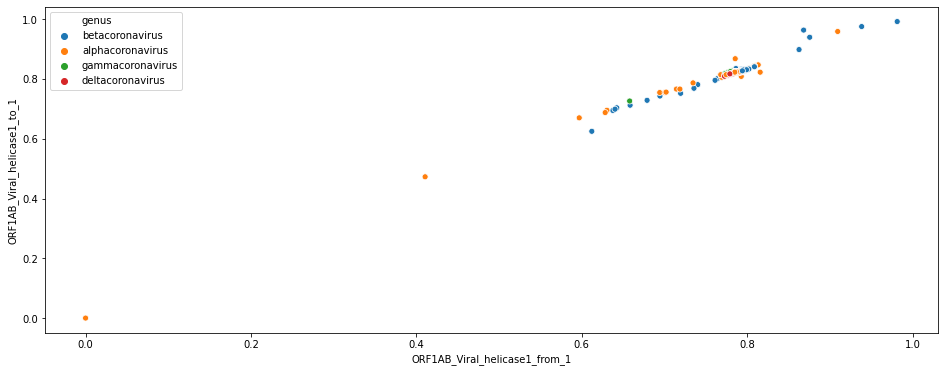

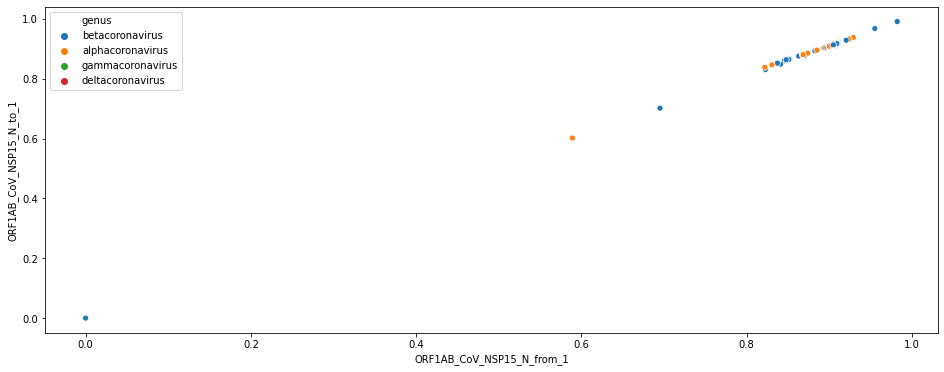

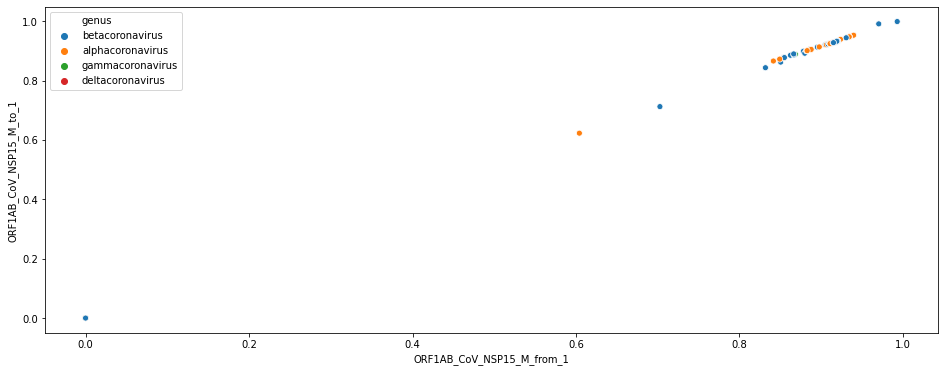

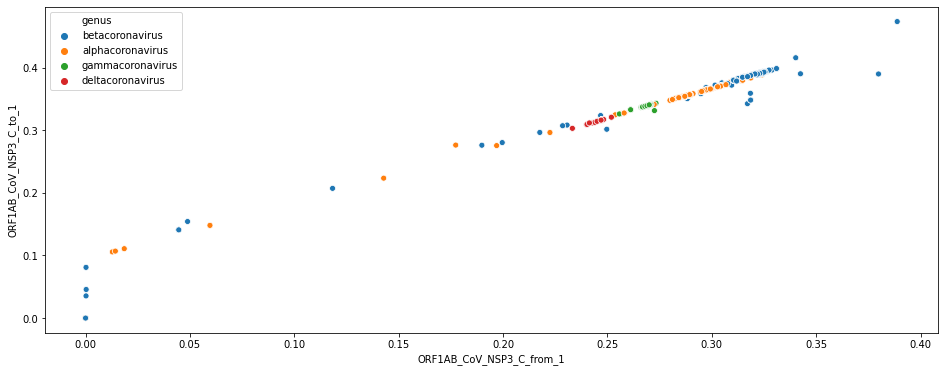

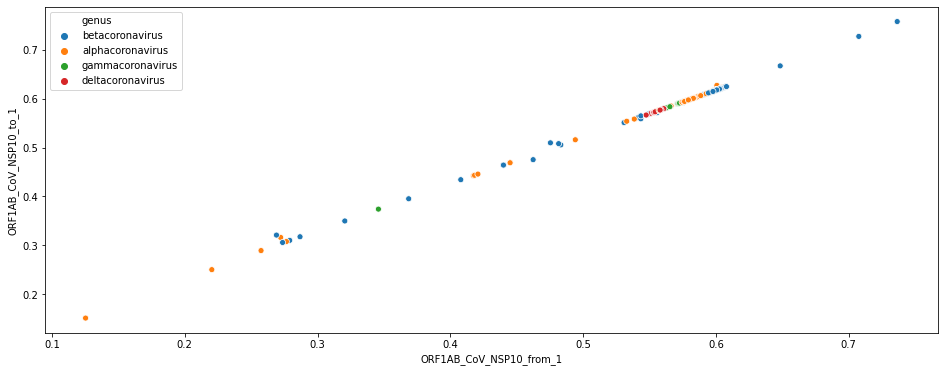

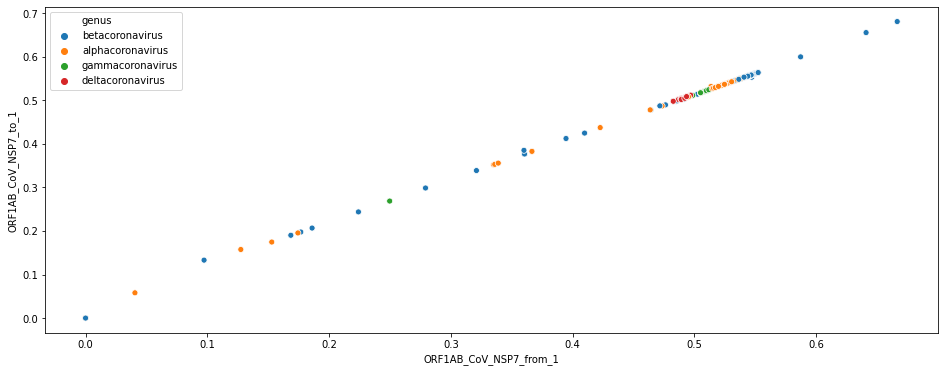

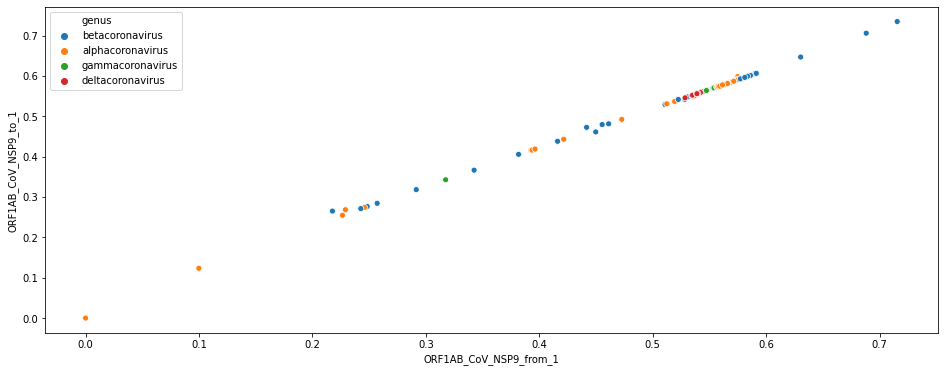

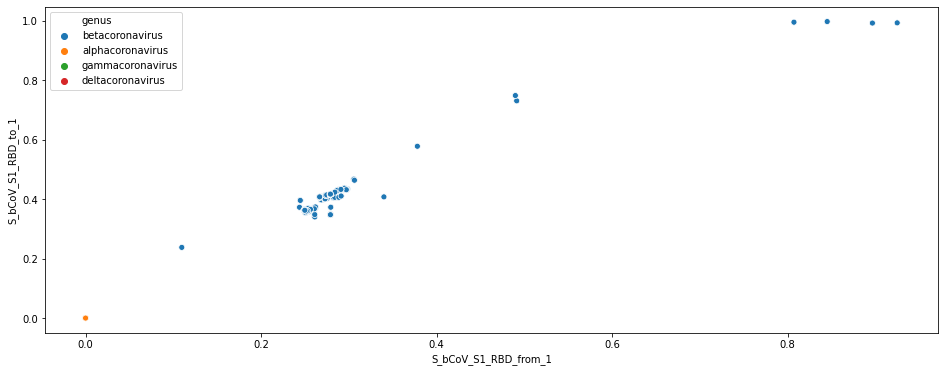

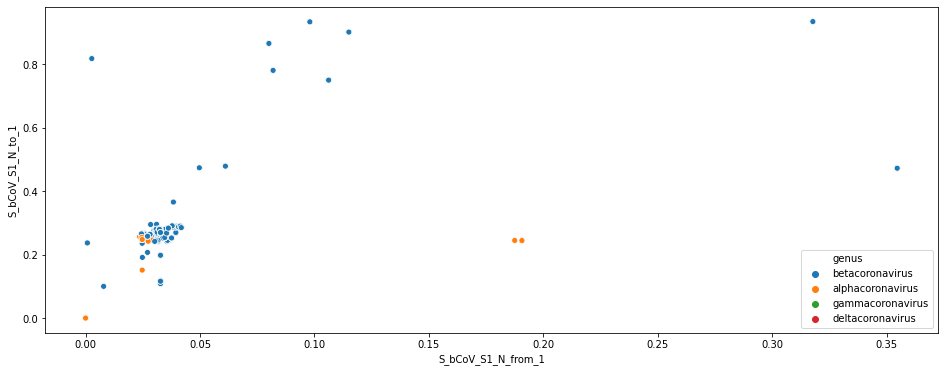

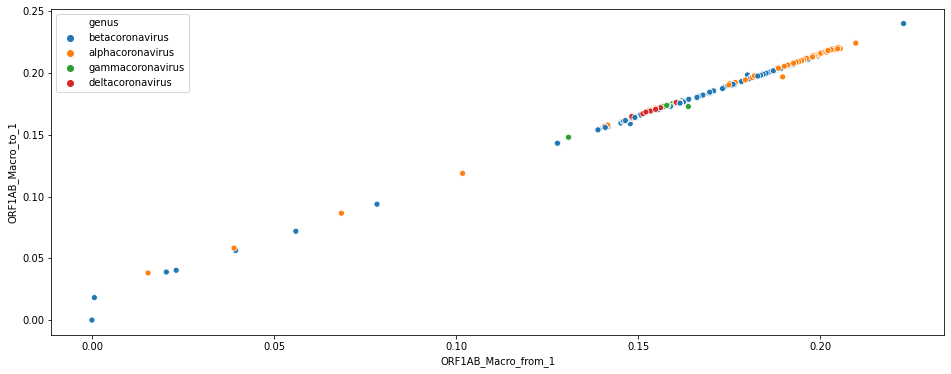

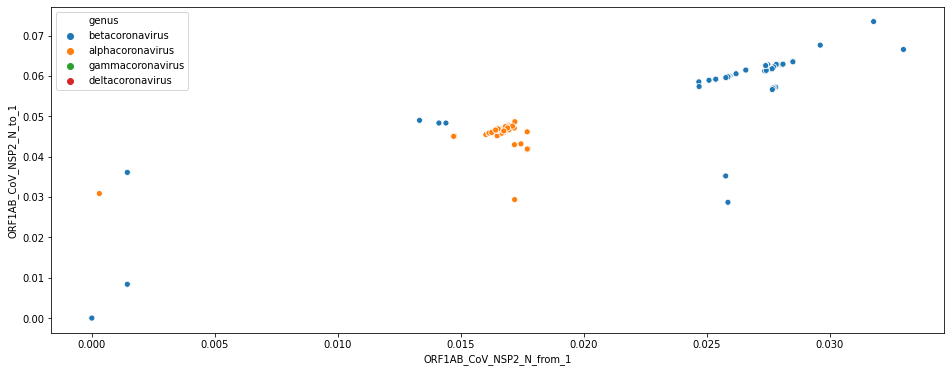

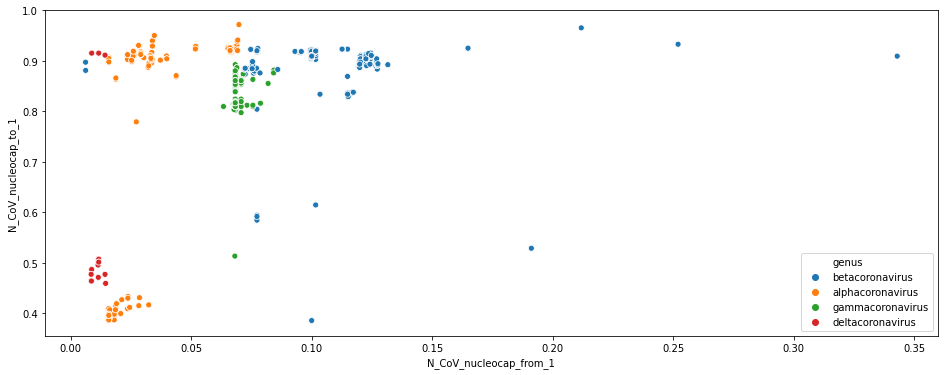

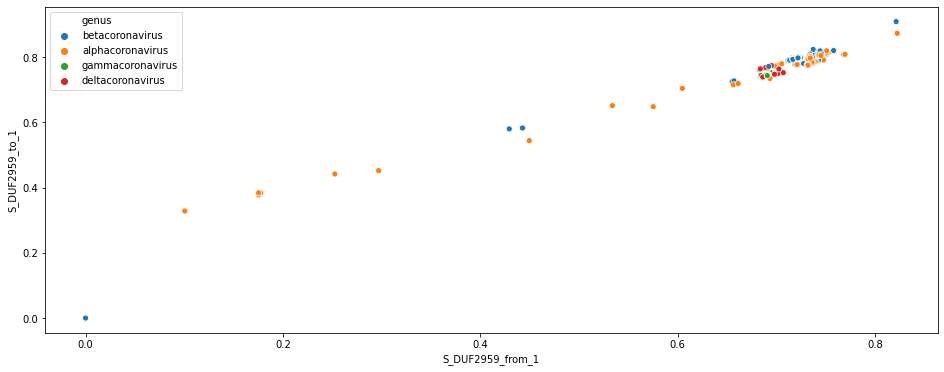

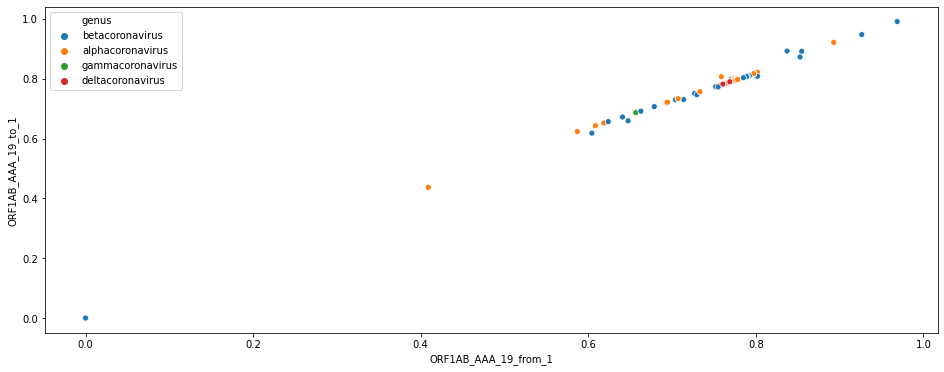

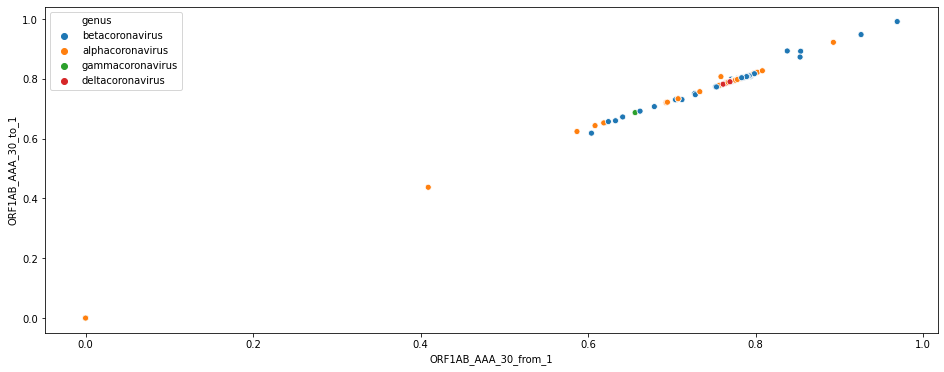

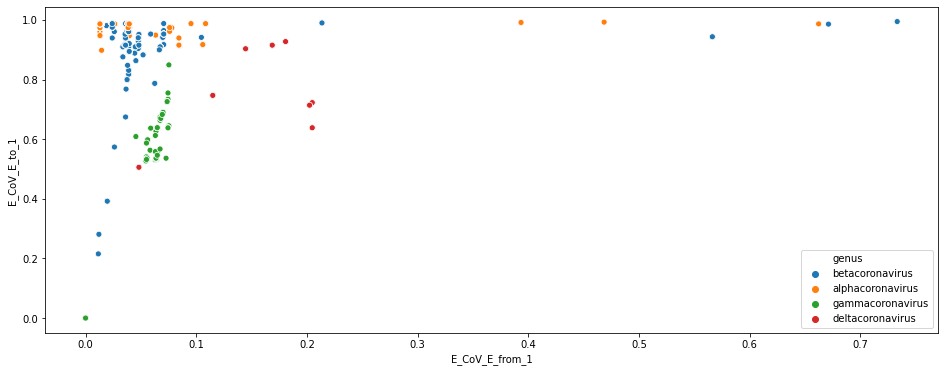

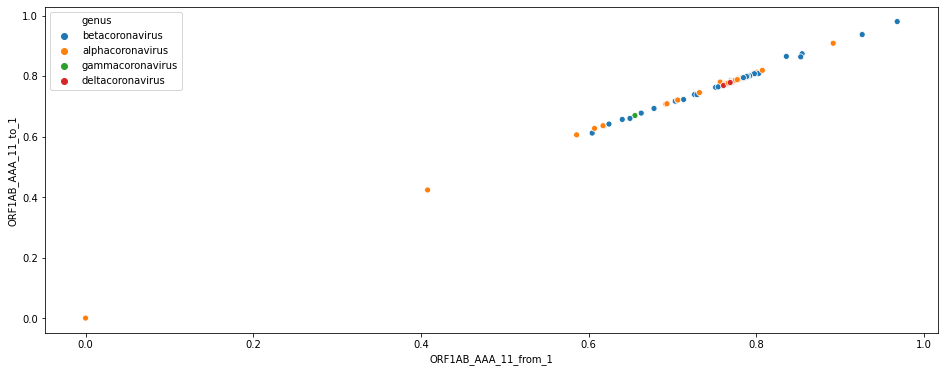

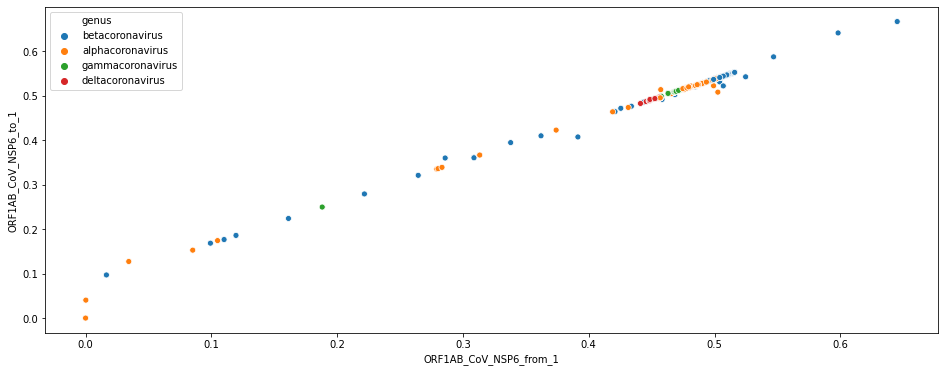

In [19]:
def plot_feature_align(class_name, from_feature, to_feature, tdf):
    plt.figure(figsize=(16, 6))

    ax = sns.scatterplot(x=from_feature, y=to_feature, hue=class_name, data=tdf)

for feature in importances.head(100).index:
    if "_from_" in feature:
        from_feature = feature
        feature = "_".join(from_feature.split("_")[:-2])
        hit = from_feature.split("_")[-1]
        to_feature = feature + "_to_" + str(hit)
        
        plot_feature_length("genus", from_feature, to_feature, genus_tdf)

Most of the relevant domains seems to be in the ORF1AB gene and a few others are on the structural proteins.

## 5.3 SARS-CoV-2 classifier

In a similar way, we can build a model to classify SARS-CoV-2 genomes out of the protein domains present in the main coding segments of the genome. We know that all the samples collected from GISAID belongs to SARS-CoV-2 viruses, and we can use those as part of our training set. We should put a cutoff date on the NCBI samples (say June 2019), assuming the strains before that are not SARS-CoV-2.

In [16]:
def get_dataset(class_name, orfs_db):
    columns = []
    for label in LABELS:
        for c in training_dfs[label].columns:
            columns.append(c)        
    columns += [class_name]

    # create dataset
    dataset_frame = {i: dict() for i in columns}

    for oid in orfs_db["id"].unique():
        for label in LABELS:
            orfs = orfs_db[orfs_db["id"] == oid]
            protein = orfs[orfs["label"] == label]

            if len(protein) > 0:
                rid = protein.index.values[0]
                tdf = training_dfs[label][training_dfs[label].index == rid]

                for z in tdf:
                    dataset_frame[z][oid] = tdf[z].values[0]

        dataset_frame[class_name][oid] = orfs.iloc[0][class_name]

    dataset = pd.DataFrame(dataset_frame)
    dataset.index.name = "id"

    return dataset

CUTOFF_DATE = pd.to_datetime("2019-06-01")

non_sars_cov_2 = corona_db[corona_db["date"] < CUTOFF_DATE]
non_sars_cov_2["strain"] = ["non-SARS-CoV-2" for i in range(0, len(non_sars_cov_2))]

print("[+] got", len(non_sars_cov_2["id"].unique()), "non SARS-CoV-2 samples")

sars_cov_2 = corona_db[corona_db.index.str.contains("EPI_ISL")]
sars_cov_2["strain"] = ["SARS-CoV-2" for i in range(0, len(sars_cov_2))]

print("[+] got", len(sars_cov_2["id"].unique()), "SARS-CoV-2 samples")

total_samples = pd.concat([non_sars_cov_2, sars_cov_2])

sars_df = get_dataset("strain", total_samples)
print("[+] got", len(sars_df), "training samples")

[+] got 2696 non SARS-CoV-2 samples
[+] got 3656 SARS-CoV-2 samples
[+] got 6350 training samples


In [17]:
kfold = 5
accuracy = 0.0

for i in range(0, kfold):
    print("[+] random forest run", i)
    # split our training set
    sars_train, sars_test = pd.DataFrame(columns=sars_df.columns), pd.DataFrame(columns=sars_df.columns)
    sars_train.index.name, sars_test.index.name = sars_df.index.name, sars_df.index.name
    for strain in sars_df["strain"].unique():
        sars_total = sars_df[sars_df["strain"] == strain]
        
        df = pd.DataFrame(np.random.randn(len(sars_total), 2))
        msk = np.random.rand(len(df)) < 0.80
        sars_train_case = sars_total[msk]
        sars_test_case = sars_total[~msk]
        
        sars_train = pd.concat([sars_train, sars_train_case])
        sars_test = pd.concat([sars_test, sars_test_case])

    # train the random forest
    sars_random_forest = train_random_forest(sars_train, "strain")

    # evaluate
    sars_predict = predict_random_forest(sars_random_forest, sars_test, "strain")
    report = evaluate_classifier(sars_test, sars_predict, "strain")

    accuracy += report["accuracy"]
    
accuracy /= kfold
print("[+] cross validation average accuracy = %.2f" %(accuracy * 100))

print("[+] final random forest run")

# train the random forest
sars_random_forest = train_random_forest(sars_df, "strain")

# evaluate
sars_predict = predict_random_forest(sars_random_forest, sars_df, "strain")
report = evaluate_classifier(sars_df, sars_predict, "strain")

importances = get_importances(sars_random_forest, sars_df.columns.values[:-1])
display(HTML(importances.head(15).to_html()))

[+] random forest run 0


,non-SARS-CoV-2,SARS-CoV-2
non-SARS-CoV-2,707,0
SARS-CoV-2,0,553


,precision,recall,f1-score,support
non-SARS-CoV-2,1.0,1.0,1.0,707.0
SARS-CoV-2,1.0,1.0,1.0,553.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,1260.0
weighted avg,1.0,1.0,1.0,1260.0


[+] random forest run 1


,non-SARS-CoV-2,SARS-CoV-2
non-SARS-CoV-2,748,0
SARS-CoV-2,0,542


,precision,recall,f1-score,support
non-SARS-CoV-2,1.0,1.0,1.0,748.0
SARS-CoV-2,1.0,1.0,1.0,542.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,1290.0
weighted avg,1.0,1.0,1.0,1290.0


[+] random forest run 2


,non-SARS-CoV-2,SARS-CoV-2
non-SARS-CoV-2,745,1
SARS-CoV-2,0,525


,precision,recall,f1-score,support
non-SARS-CoV-2,1.000000,0.998660,0.999329,746.000000
SARS-CoV-2,0.998099,1.000000,0.999049,525.000000
accuracy,0.999213,0.999213,0.999213,0.999213
macro avg,0.999049,0.999330,0.999189,1271.000000
weighted avg,0.999215,0.999213,0.999213,1271.000000


[+] random forest run 3


,non-SARS-CoV-2,SARS-CoV-2
non-SARS-CoV-2,717,0
SARS-CoV-2,0,535


,precision,recall,f1-score,support
non-SARS-CoV-2,1.0,1.0,1.0,717.0
SARS-CoV-2,1.0,1.0,1.0,535.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,1252.0
weighted avg,1.0,1.0,1.0,1252.0


[+] random forest run 4


,non-SARS-CoV-2,SARS-CoV-2
non-SARS-CoV-2,731,0
SARS-CoV-2,0,569


,precision,recall,f1-score,support
non-SARS-CoV-2,1.0,1.0,1.0,731.0
SARS-CoV-2,1.0,1.0,1.0,569.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,1300.0
weighted avg,1.0,1.0,1.0,1300.0


[+] cross validation average accuracy = 99.98
[+] final random forest run


,non-SARS-CoV-2,SARS-CoV-2
non-SARS-CoV-2,3654,0
SARS-CoV-2,0,2696


,precision,recall,f1-score,support
non-SARS-CoV-2,1.0,1.0,1.0,3654.0
SARS-CoV-2,1.0,1.0,1.0,2696.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,6350.0
weighted avg,1.0,1.0,1.0,6350.0


,importances
E_length,0.092794
ORF1AB_bCoV_PL2pro_hits,0.058744
ORF1AB_CoV_peptidase_from_1,0.046924
ORF1AB_bCoV_SUD-M_to_1,0.046832
ORF1AB_CoV_peptidase_to_1,0.046616
ORF1AB_CoV_NSP15_N_to_1,0.046092
ORF1AB_bCoV_SUD-M_from_1,0.046008
ORF1AB_bCoV_NAR_from_1,0.044586
ORF1AB_CoV_NSP15_M_score_1,0.039635
ORF1AB_bCoV_PL2pro_from_1,0.038557


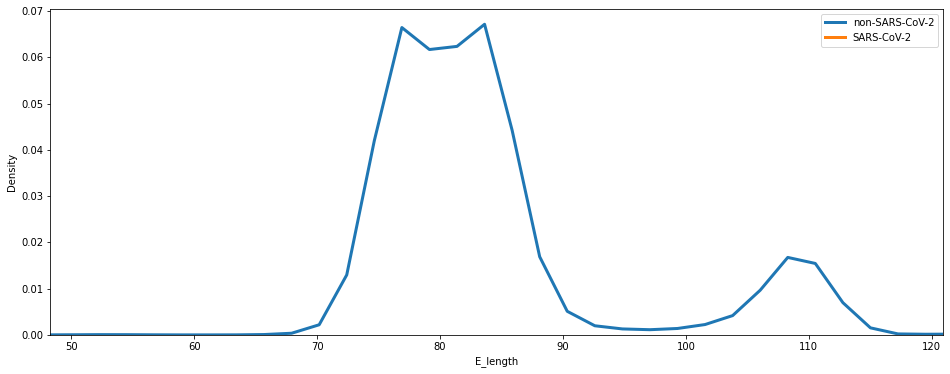

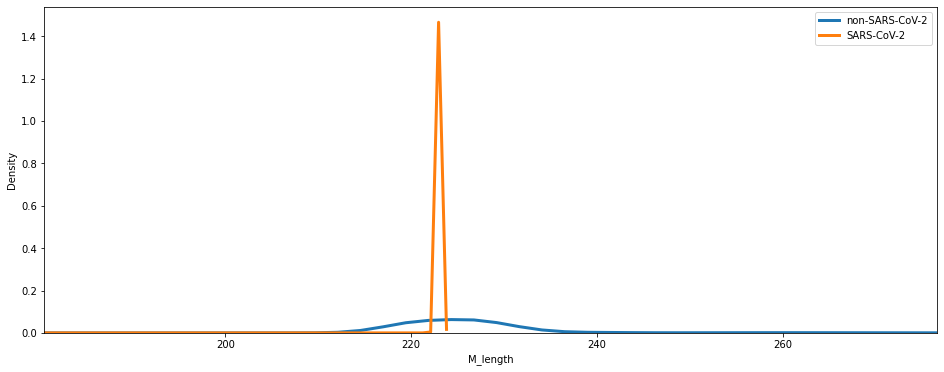

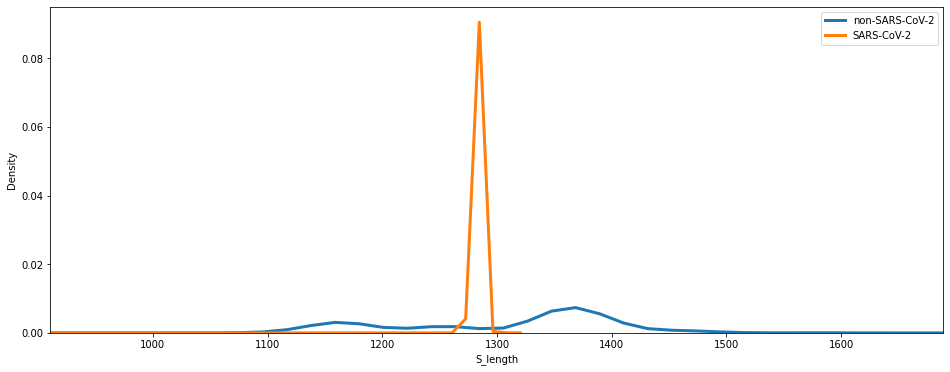

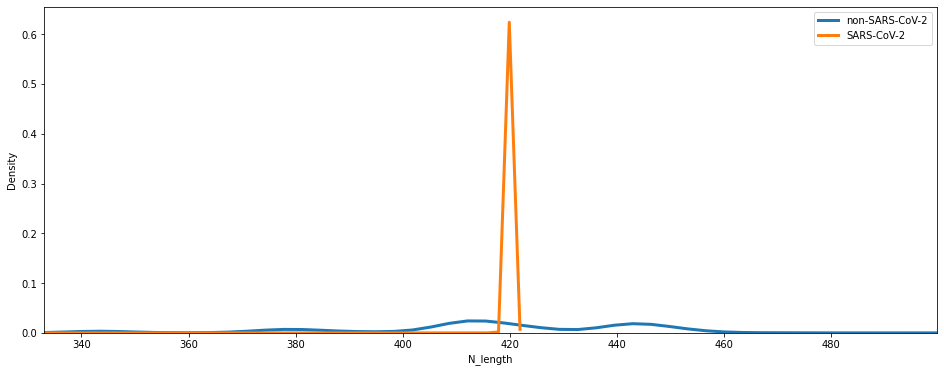

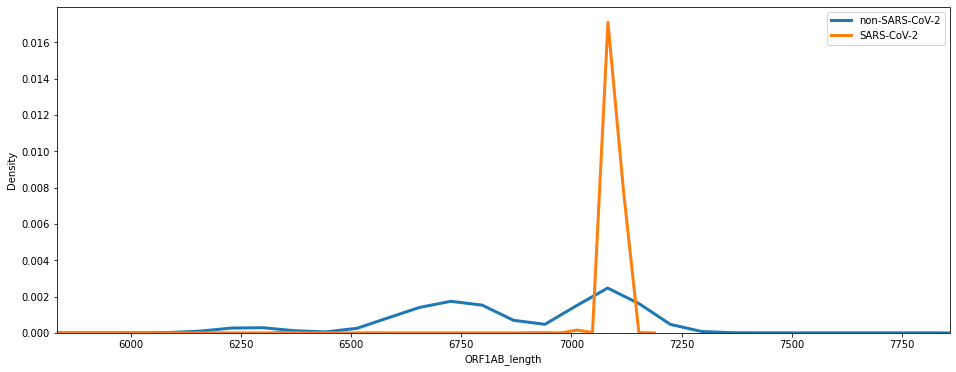

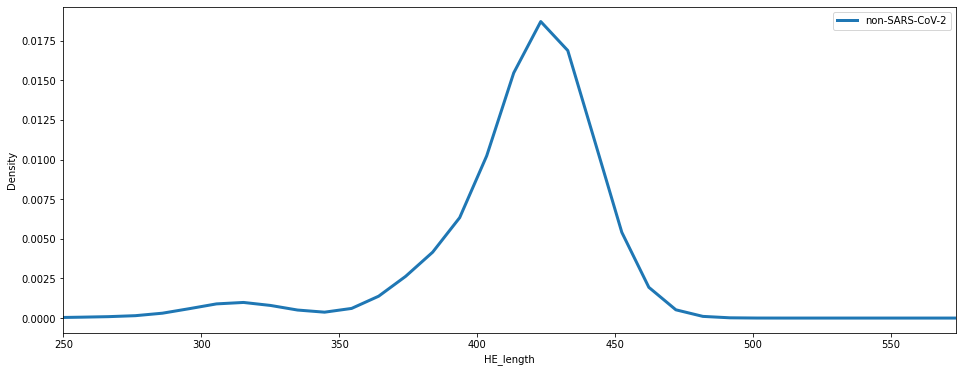

In [26]:
# Plot formatting
for feature in importances.index:
    if "length" in feature:
        plot_feature_length("strain", sars_df, feature)

In [44]:
print(sars_cov_2[(sars_cov_2["label"] == "S") & (sars_cov_2["length"] < 2500)])
display_info("EPI_ISL_418383")
print(sars_df)
print(sars_df[sars_df.index == "EPI_ISL_418383@21535"])

                                  id type label       date collection  \
rid                                                                     
EPI_ISL_418383@21535  EPI_ISL_418383  ORF     S 2020-01-01       2020   
EPI_ISL_418383@23525  EPI_ISL_418383  ORF     S 2020-01-01       2020   
EPI_ISL_421245@21511  EPI_ISL_421245  ORF     S 2020-01-25       2020   

                                                                   path  \
rid                                                                       
EPI_ISL_418383@21535  ./data/gisaid/coronaviridae/gisaid_cov2020_seq...   
EPI_ISL_418383@23525  ./data/gisaid/coronaviridae/gisaid_cov2020_seq...   
EPI_ISL_421245@21511  ./data/gisaid/coronaviridae/gisaid_cov2020_seq...   

                      start    end  length  \
rid                                          
EPI_ISL_418383@21535  21535  23599    2064   
EPI_ISL_418383@23525  23525  25385    1860   
EPI_ISL_421245@21511  21511  21973     462   

                           

,length,date,information,description,genus,subgenus,unknown,country,host,strain,collection_date
id,,,,,,,,,,,
EPI_ISL_418383,29904,2020-01-01,1.196172,hCoV-19/Canada/ON_PHL2273/2020|EPI_ISL_418383|2020,unknown,unknown,0.009698,canada,homo sapiens,hCoV-19,2020


,type,label,date,collection,start,end,length,genus,subgenus,unknown
rid,,,,,,,,,,
EPI_ISL_418383@00000,UTR,5UTR,2020-01-01,2020,0,265,265,unknown,unknown,0.196226
EPI_ISL_418383@00265,ORF,ORF1A,2020-01-01,2020,265,13483,13218,unknown,unknown,0.000757
EPI_ISL_418383@00266,ORF,ORF1AB,2020-01-01,2020,265,21555,21291,unknown,unknown,0.011178
EPI_ISL_418383@21535,ORF,S,2020-01-01,2020,21535,23599,2064,unknown,unknown,0.000484
EPI_ISL_418383@23525,ORF,S,2020-01-01,2020,23525,25385,1860,unknown,unknown,0.100538
EPI_ISL_418383@25332,ORF,UNDEF,2020-01-01,2020,25332,25449,117,unknown,unknown,0.000000
EPI_ISL_418383@25393,ORF,UNDEF,2020-01-01,2020,25393,26221,828,unknown,unknown,0.000000
EPI_ISL_418383@26183,ORF,UNDEF,2020-01-01,2020,26183,26282,99,unknown,unknown,0.000000
EPI_ISL_418383@26245,ORF,E,2020-01-01,2020,26245,26473,228,unknown,unknown,0.000000


             ORF1AB_length  ORF1AB_2_5_RNA_ligase2_hits  \
id                                                        
AB257344.1          7074.0                          0.0   
AB354579.1          7095.0                          0.0   
AB551247.1          7169.0                          0.0   
AC_000192.1         7181.0                          0.0   
AF029248.1          7179.0                          0.0   
...                    ...                          ...   
KF530115.1             NaN                          NaN   
MF685025.1             NaN                          NaN   
MG600028.1             NaN                          NaN   
MG600030.1             NaN                          NaN   
MG600031.1             NaN                          NaN   

             ORF1AB_2_5_RNA_ligase2_from_1  ORF1AB_2_5_RNA_ligase2_to_1  \
id                                                                        
AB257344.1                             0.0                          0.0   
AB35457

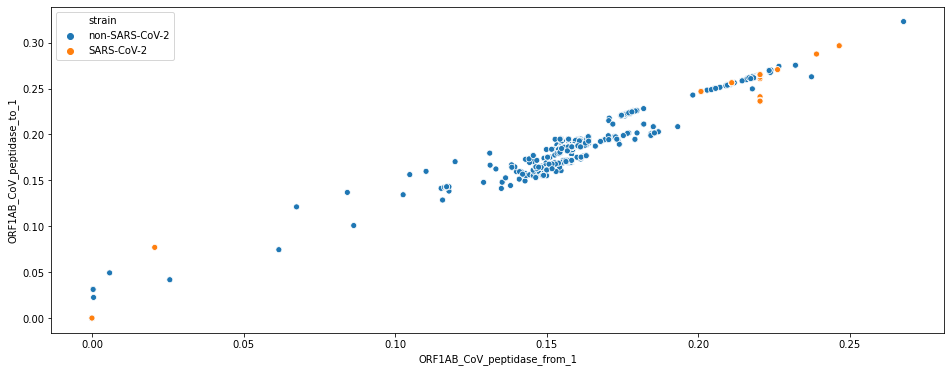

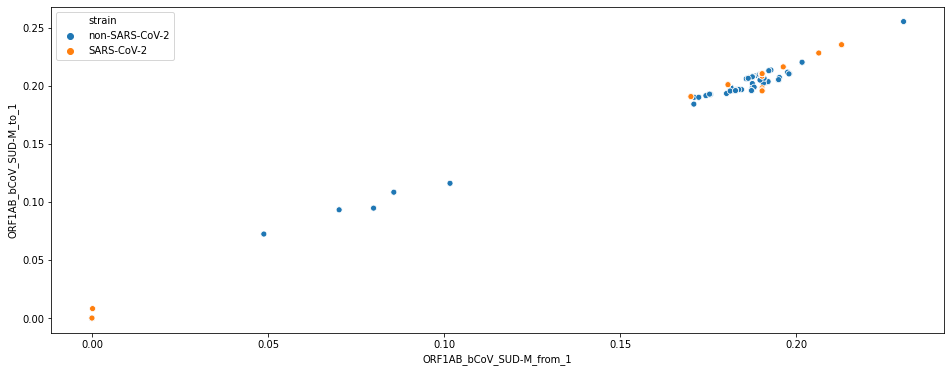

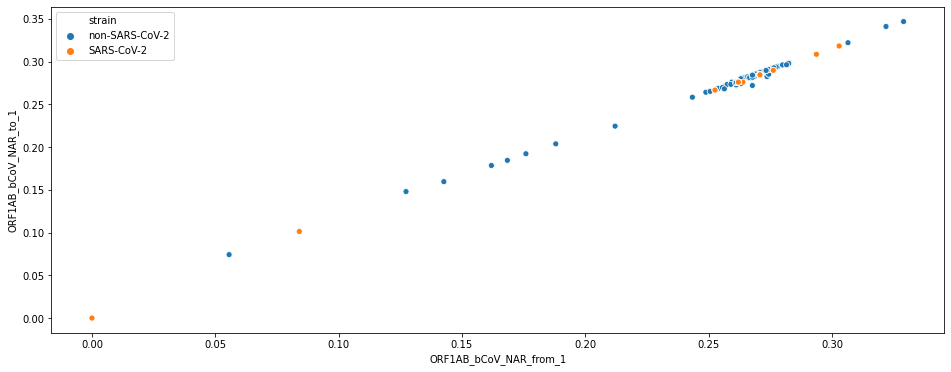

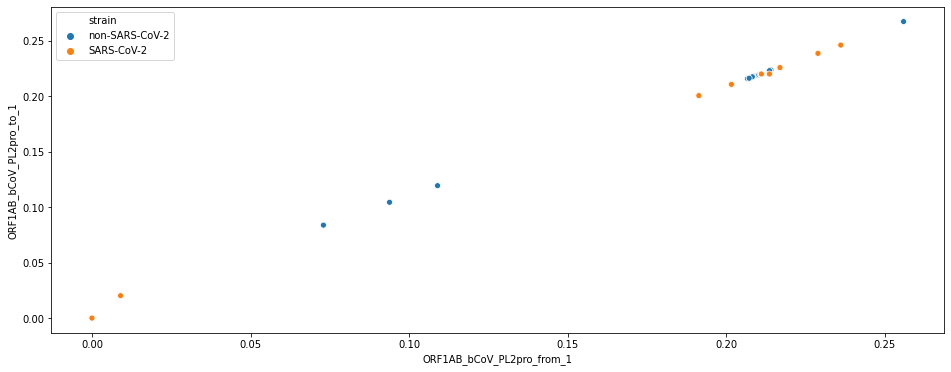

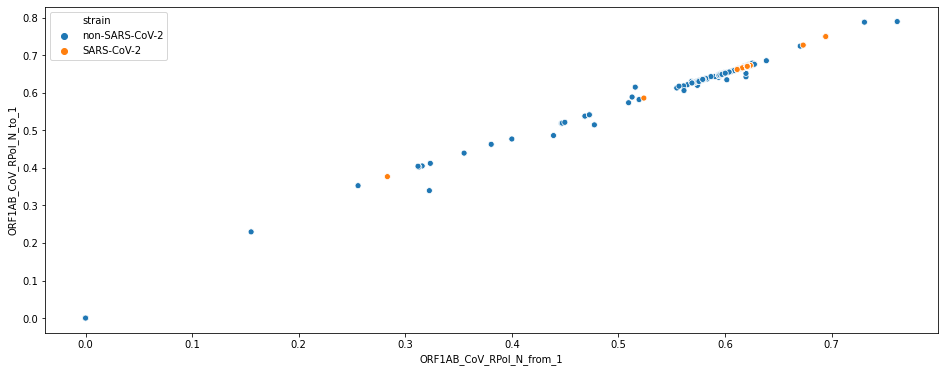

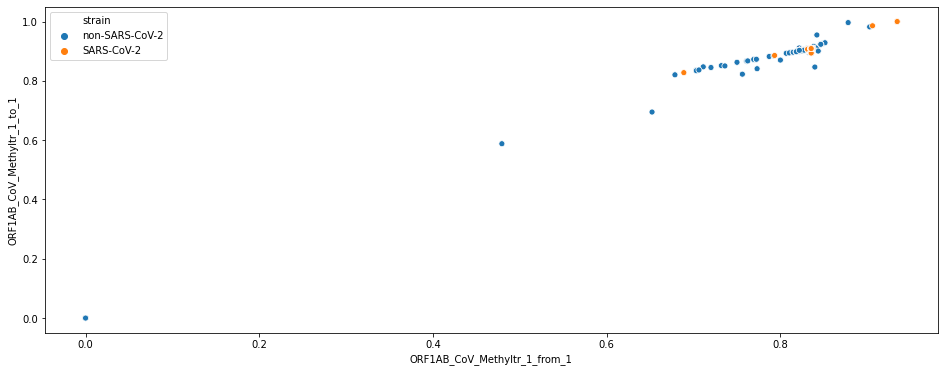

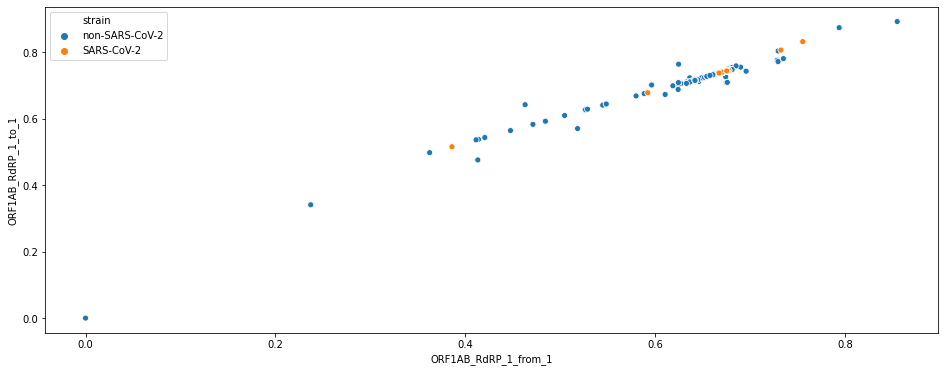

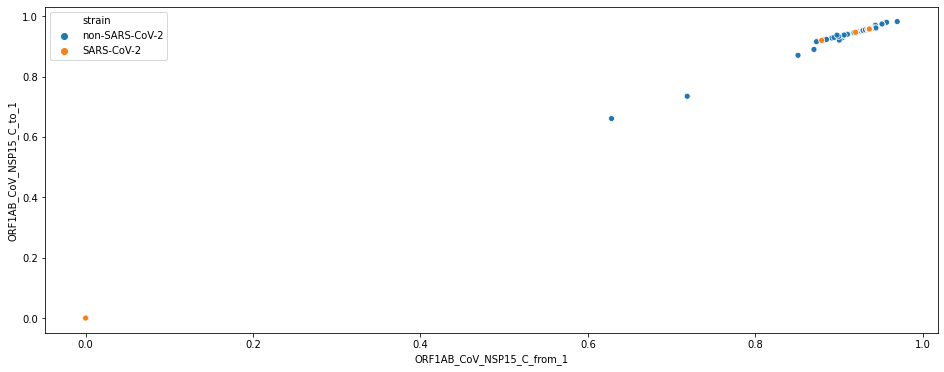

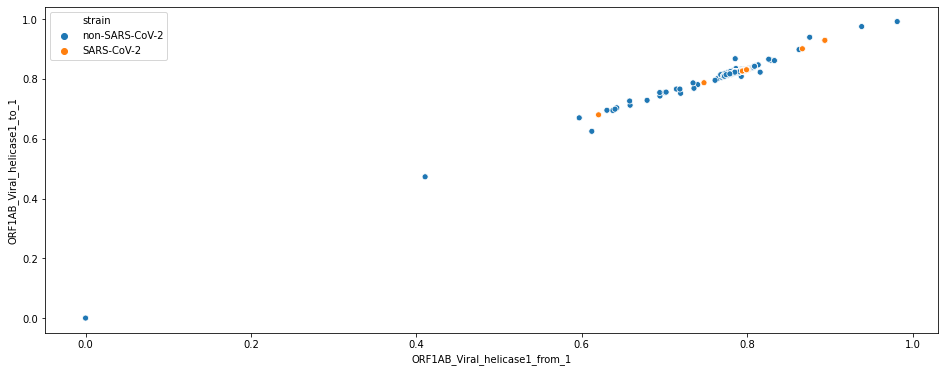

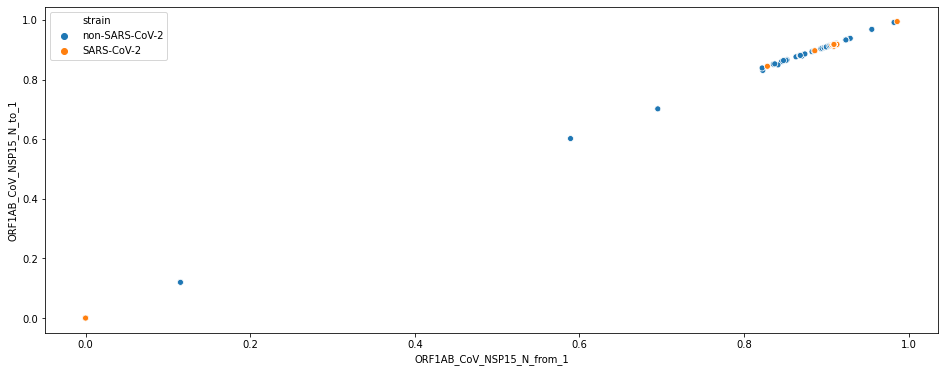

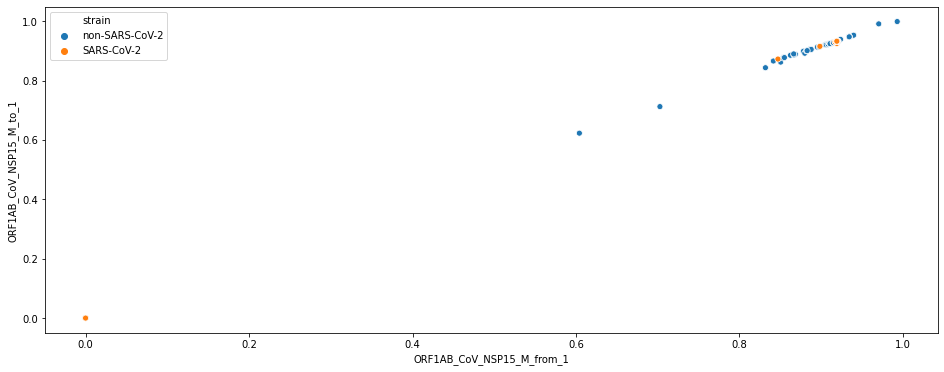

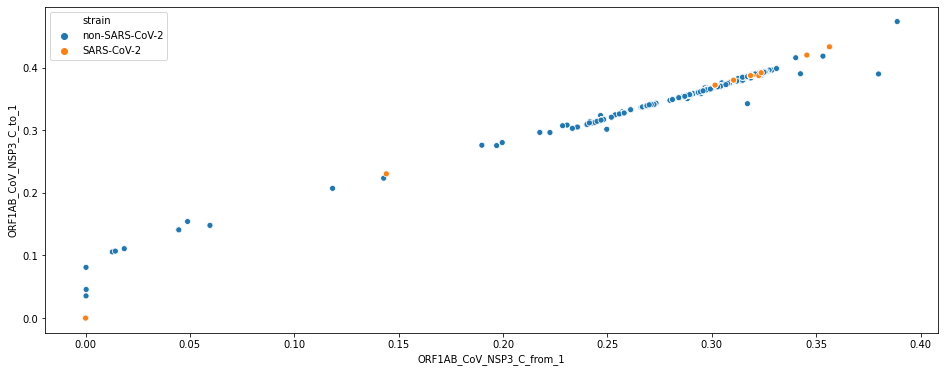

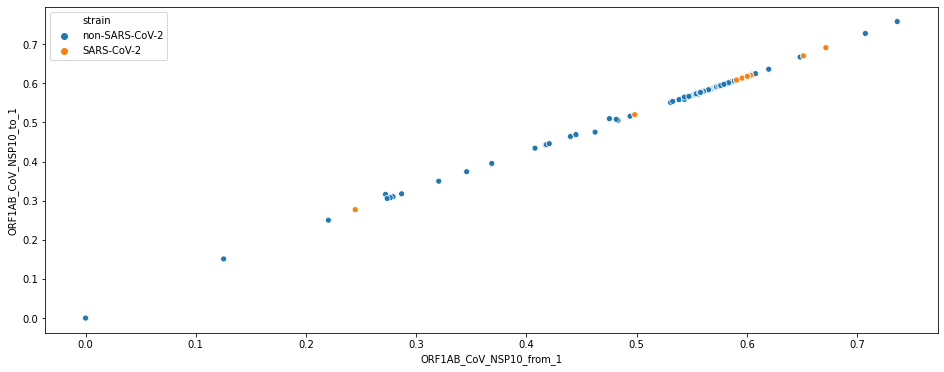

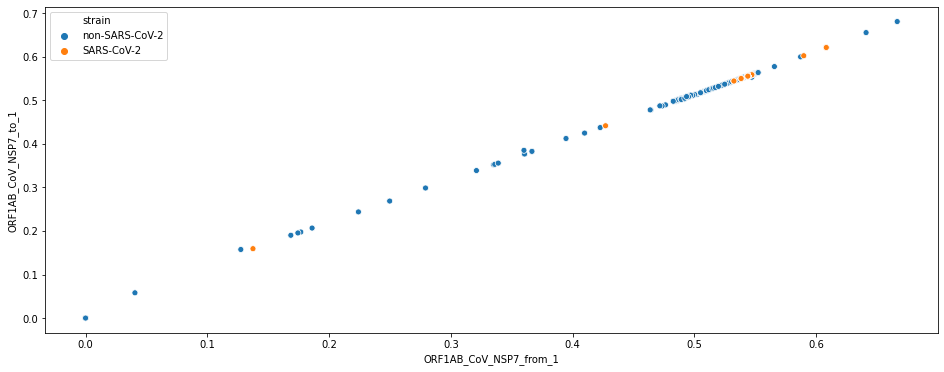

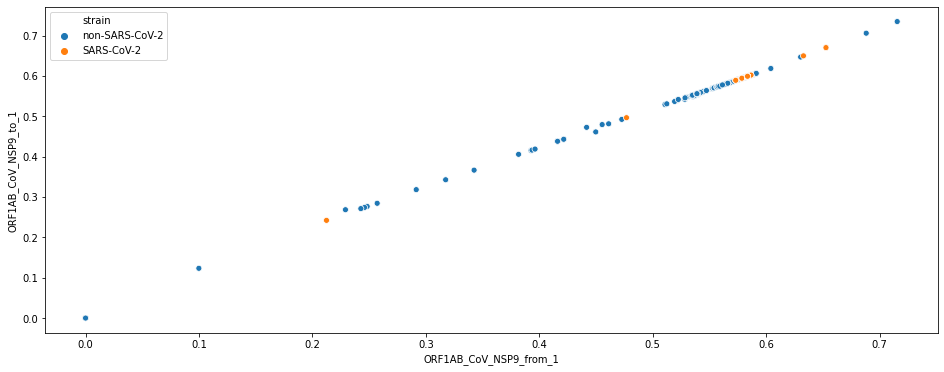

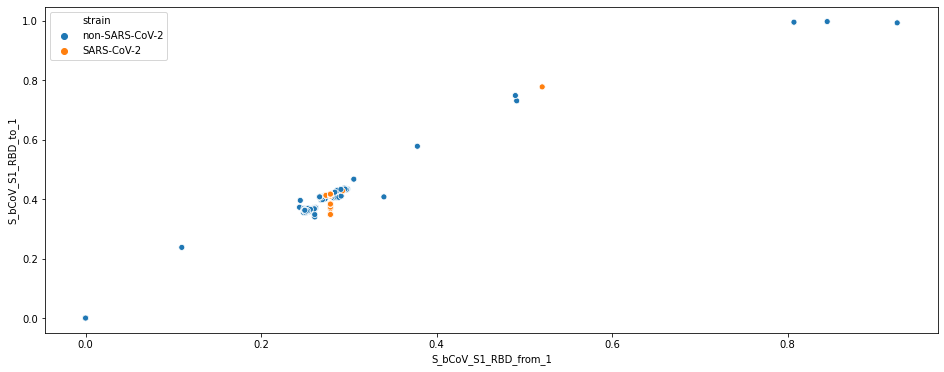

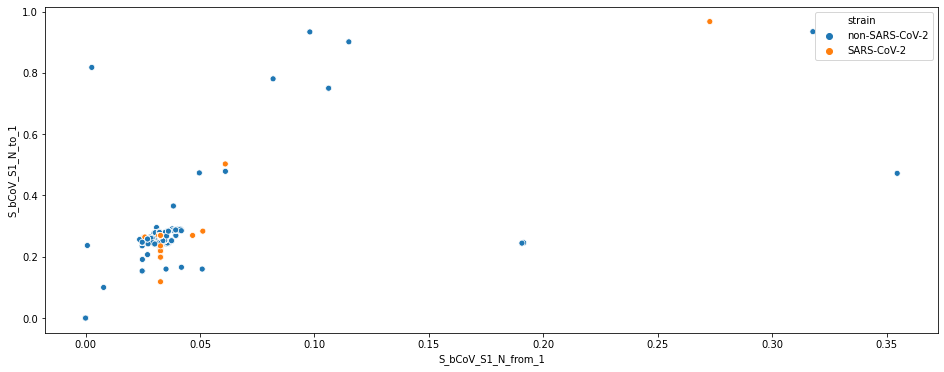

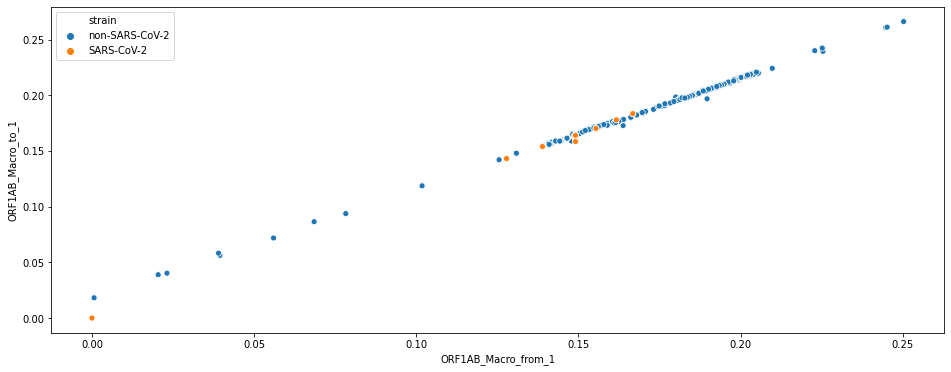

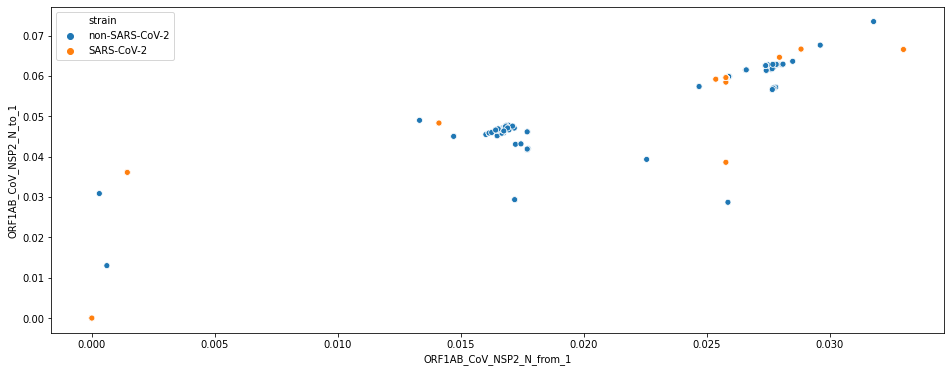

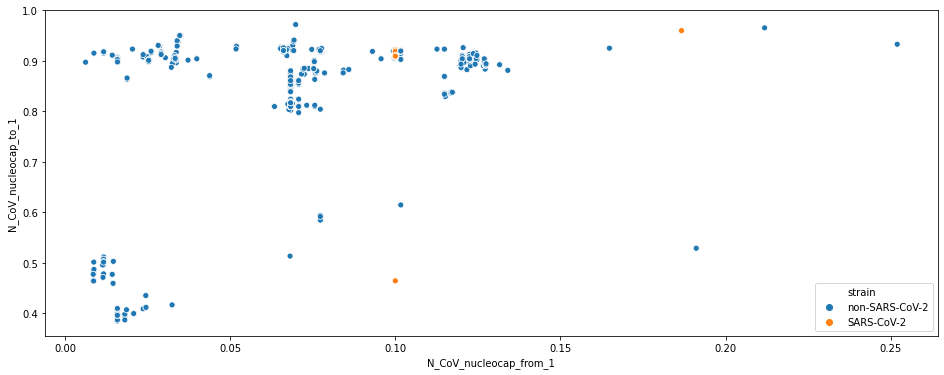

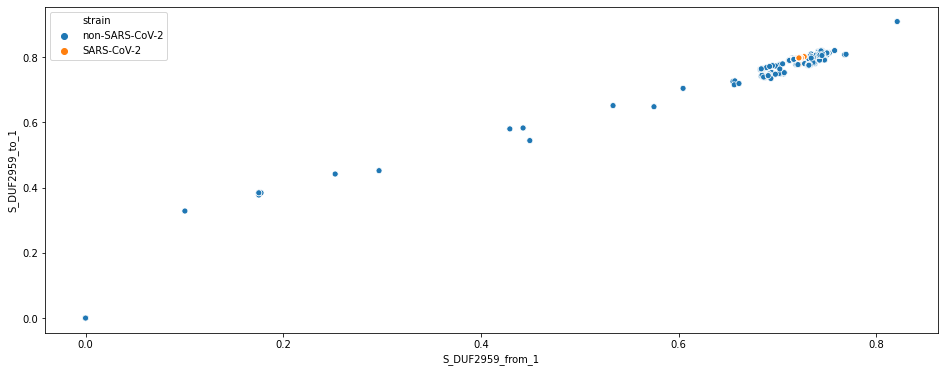

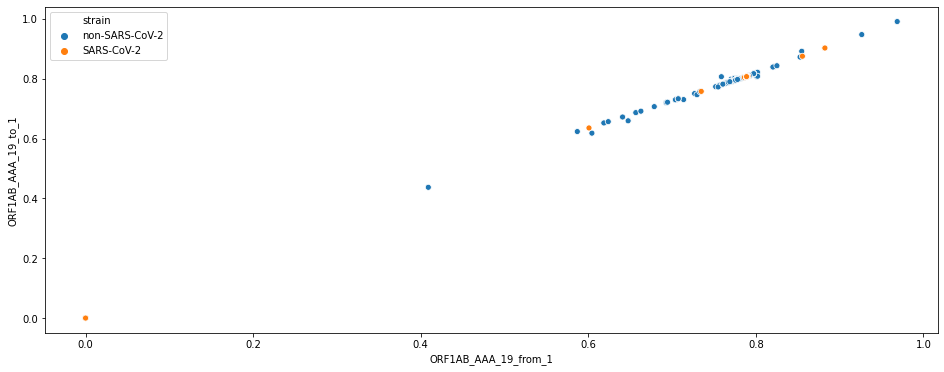

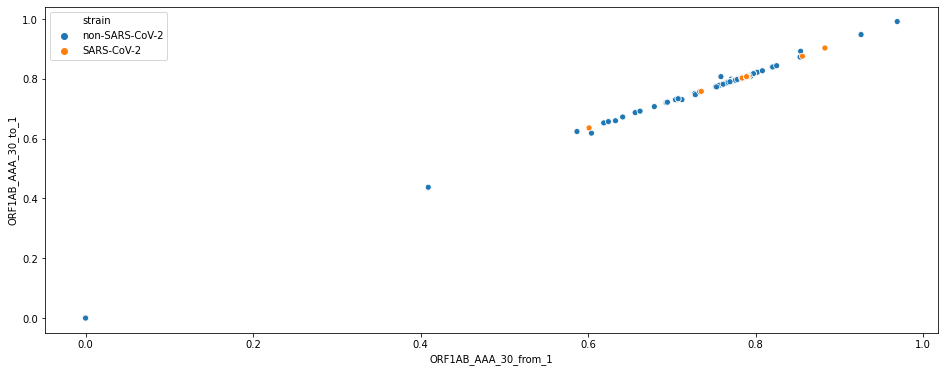

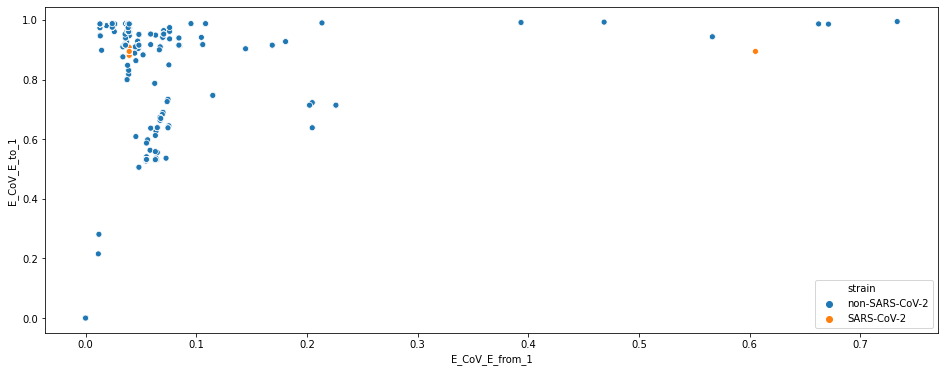

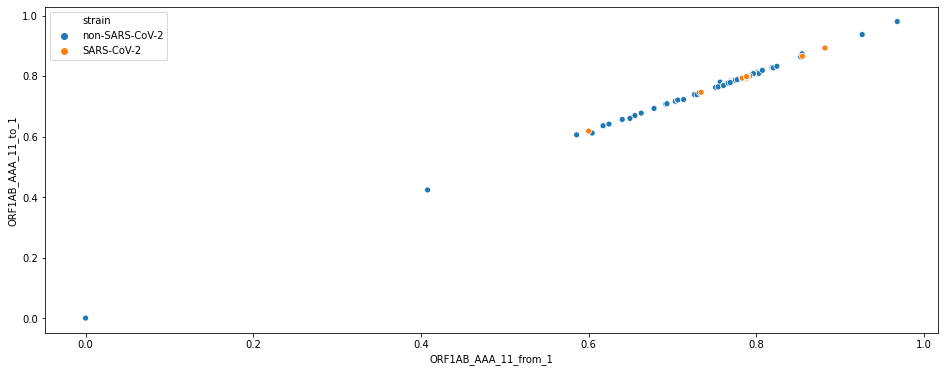

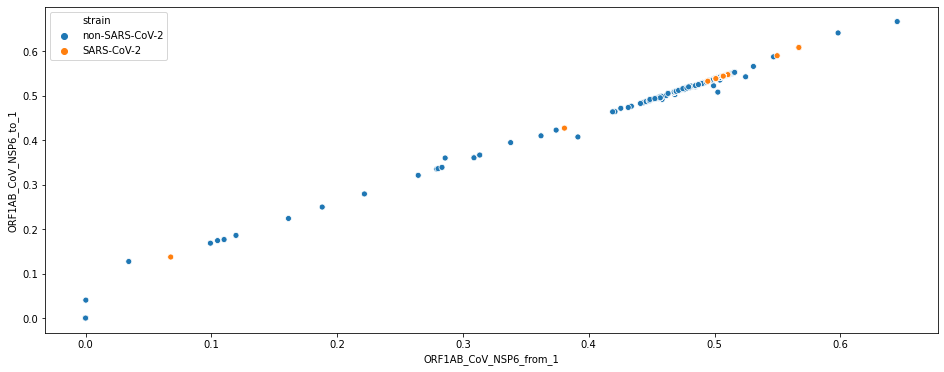

In [27]:
for feature in importances.head(100).index:
    if "_from_" in feature:
        from_feature = feature
        feature = "_".join(from_feature.split("_")[:-2])
        hit = from_feature.split("_")[-1]
        to_feature = feature + "_to_" + str(hit)
        
        plot_feature_align("strain", from_feature, to_feature, sars_df)